In [1]:
import os
import time
import tqdm
import inceptionv3
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from albumentations import *
import utils
import defense

/home/eason/anaconda3/envs/untitled/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eason/anaconda3/envs/untitled/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eason/anaconda3/envs/untitled/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eason/anaconda3/envs/untitled/lib/pyt

In [2]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)

In [3]:
data_path = "./data"
output_path = "./finalresults"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
cleandata = np.load(os.path.join(data_path, "clean100data.npy"))
cleanlabel = np.load(os.path.join(data_path, "clean100label.npy"))
targets = np.load(os.path.join(data_path, "random_targets.npy"))

In [5]:
xs = tf.placeholder(tf.float32, (299, 299, 3))
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
label = tf.placeholder(tf.int32, ())
one_hot = tf.expand_dims(tf.one_hot(label, 1000), axis=0)

lam = 1e-6
epsilon = 0.05
max_steps = 50 #only extracting first 50 rounds of results
LR = 0.1

label = tf.placeholder(tf.int32, ())
one_hot = tf.expand_dims(tf.one_hot(label, 1000), axis=0)

logits, preds = inceptionv3.model(sess, tf.expand_dims(xs, axis=0))
l2_loss = tf.sqrt(2 * tf.nn.l2_loss(l2_x - l2_orig) /299/299/3)

labels = tf.tile(one_hot, (logits.shape[0], 1))
xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
loss = xent + lam * tf.maximum(l2_loss - epsilon, 0)
grad, = tf.gradients(loss, xs)

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/eason/Research/Paris/ALL_Defense/data/inception_v3.ckpt


In [6]:
max_steps = 100

# SSR

In [7]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = defense.defend_PROTAT(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_bpda, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

  0%|          | 0/100 [00:00<?, ?it/s]/home/eason/anaconda3/envs/untitled/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
 38%|███▊      | 38/100 [20:21<25:08, 24.33s/it]

Found AE. Iter: 12. L2: 0.00945202074944973.


 57%|█████▋    | 57/100 [30:17<16:54, 23.58s/it]

Found AE. Iter: 5. L2: 0.01499212346971035.


 60%|██████    | 60/100 [31:25<13:41, 20.54s/it]

Found AE. Iter: 5. L2: 0.011903501115739346.


 66%|██████▌   | 66/100 [34:14<12:48, 22.61s/it]

Found AE. Iter: 8. L2: 0.011903461068868637.


 75%|███████▌  | 75/100 [38:46<10:17, 24.68s/it]

Found AE. Iter: 18. L2: 0.011510740034282207.


 81%|████████  | 81/100 [41:33<07:09, 22.62s/it]

Found AE. Iter: 5. L2: 0.008372845128178596.


 92%|█████████▏| 92/100 [47:18<03:36, 27.05s/it]

Found AE. Iter: 39. L2: 0.011434557847678661.


 94%|█████████▍| 94/100 [47:59<02:14, 22.47s/it]

Found AE. Iter: 22. L2: 0.010968650691211224.


 95%|█████████▌| 95/100 [47:59<01:20, 16.01s/it]

Found AE. Iter: 2. L2: 0.005830556154251099.


 96%|█████████▌| 96/100 [48:14<01:02, 15.65s/it]

Found AE. Iter: 44. L2: 0.01118090283125639.


100%|██████████| 100/100 [50:26<00:00, 30.26s/it]


In [8]:
np.save(output_path+'/PROTAT_PGD_Acc.npy', acclist)
np.save(output_path+'/PROTAT_PGD_Suc.npy', succlist)

# RAND

In [9]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = defense.defend_RAND(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_bpda, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

  5%|▌         | 5/100 [00:26<07:35,  4.80s/it]

Found AE. Iter: 29. L2: 0.00776209682226181.


  6%|▌         | 6/100 [00:26<05:26,  3.47s/it]

Found AE. Iter: 5. L2: 0.005834672600030899.


 10%|█         | 10/100 [00:48<06:59,  4.66s/it]

Found AE. Iter: 55. L2: 0.013359928503632545.


 19%|█▉        | 19/100 [01:39<06:40,  4.94s/it]

Found AE. Iter: 46. L2: 0.009340536780655384.


 29%|██▉       | 29/100 [02:35<05:51,  4.96s/it]

Found AE. Iter: 39. L2: 0.008424588479101658.


 33%|███▎      | 33/100 [02:56<05:06,  4.57s/it]

Found AE. Iter: 31. L2: 0.00871745590120554.


 34%|███▍      | 34/100 [02:56<03:47,  3.45s/it]

Found AE. Iter: 13. L2: 0.007767698727548122.


 38%|███▊      | 38/100 [03:15<03:53,  3.76s/it]

Found AE. Iter: 6. L2: 0.009401265531778336.


 40%|████      | 40/100 [03:22<03:19,  3.32s/it]

Found AE. Iter: 10. L2: 0.01741942949593067.


 41%|████      | 41/100 [03:24<02:52,  2.93s/it]

Found AE. Iter: 32. L2: 0.008467623963952065.


 51%|█████     | 51/100 [04:19<03:35,  4.40s/it]

Found AE. Iter: 13. L2: 0.0043652174063026905.


 53%|█████▎    | 53/100 [04:26<02:46,  3.55s/it]

Found AE. Iter: 5. L2: 0.017905868589878082.


 57%|█████▋    | 57/100 [04:48<03:27,  4.83s/it]

Found AE. Iter: 63. L2: 0.014992115087807178.


 60%|██████    | 60/100 [05:01<02:39,  3.99s/it]

Found AE. Iter: 7. L2: 0.011894475668668747.


 62%|██████▏   | 62/100 [05:08<02:17,  3.61s/it]

Found AE. Iter: 19. L2: 0.008096217177808285.


 66%|██████▌   | 66/100 [05:28<02:18,  4.07s/it]

Found AE. Iter: 19. L2: 0.012196749448776245.


 67%|██████▋   | 67/100 [05:32<02:17,  4.16s/it]

Found AE. Iter: 71. L2: 0.011066094040870667.


 73%|███████▎  | 73/100 [06:05<02:03,  4.58s/it]

Found AE. Iter: 27. L2: 0.009017027914524078.


 75%|███████▌  | 75/100 [06:12<01:36,  3.84s/it]

Found AE. Iter: 18. L2: 0.010611013509333134.


 76%|███████▌  | 76/100 [06:13<01:13,  3.06s/it]

Found AE. Iter: 19. L2: 0.006715588271617889.


 79%|███████▉  | 79/100 [06:26<01:15,  3.58s/it]

Found AE. Iter: 18. L2: 0.006756421644240618.


 81%|████████  | 81/100 [06:33<00:59,  3.12s/it]

Found AE. Iter: 3. L2: 0.008371880277991295.


 82%|████████▏ | 82/100 [06:34<00:46,  2.59s/it]

Found AE. Iter: 21. L2: 0.009684286080300808.


 83%|████████▎ | 83/100 [06:36<00:39,  2.31s/it]

Found AE. Iter: 26. L2: 0.00533804576843977.


 86%|████████▌ | 86/100 [06:49<00:46,  3.32s/it]

Found AE. Iter: 19. L2: 0.009261885657906532.


 91%|█████████ | 91/100 [07:17<00:45,  5.02s/it]

Found AE. Iter: 70. L2: 0.007312837056815624.


 92%|█████████▏| 92/100 [07:18<00:29,  3.72s/it]

Found AE. Iter: 10. L2: 0.009741882793605328.


 93%|█████████▎| 93/100 [07:23<00:29,  4.16s/it]

Found AE. Iter: 84. L2: 0.007355502340942621.


 94%|█████████▍| 94/100 [07:23<00:18,  3.02s/it]

Found AE. Iter: 5. L2: 0.011309634894132614.


 95%|█████████▌| 95/100 [07:24<00:11,  2.28s/it]

Found AE. Iter: 8. L2: 0.009571988135576248.


 96%|█████████▌| 96/100 [07:25<00:07,  1.89s/it]

Found AE. Iter: 15. L2: 0.011196342296898365.


100%|██████████| 100/100 [07:50<00:00,  4.70s/it]


In [10]:
np.save(output_path+'/RAND_PGD_Acc.npy', acclist)
np.save(output_path+'/RAND_PGD_Suc.npy', succlist)

# CROP

In [11]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = defense.defend_CROP(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_bpda, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

  5%|▌         | 5/100 [00:19<05:47,  3.66s/it]

Found AE. Iter: 30. L2: 0.007179506588727236.


 19%|█▉        | 19/100 [01:20<04:45,  3.52s/it]

Found AE. Iter: 23. L2: 0.009330200031399727.


 33%|███▎      | 33/100 [02:21<04:02,  3.62s/it]

Found AE. Iter: 37. L2: 0.008736188523471355.


 37%|███▋      | 37/100 [02:36<03:42,  3.53s/it]

Found AE. Iter: 53. L2: 0.009404074400663376.


 38%|███▊      | 38/100 [02:37<02:42,  2.63s/it]

Found AE. Iter: 12. L2: 0.00948210060596466.


 40%|████      | 40/100 [02:41<02:20,  2.34s/it]

Found AE. Iter: 14. L2: 0.01461593434214592.


 53%|█████▎    | 53/100 [03:40<03:26,  4.39s/it]

Found AE. Iter: 90. L2: 0.01792159304022789.


 57%|█████▋    | 57/100 [03:54<02:19,  3.25s/it]

Found AE. Iter: 6. L2: 0.014992140233516693.


 60%|██████    | 60/100 [04:04<01:53,  2.84s/it]

Found AE. Iter: 6. L2: 0.012031064368784428.


 64%|██████▍   | 64/100 [04:19<02:02,  3.40s/it]

Found AE. Iter: 41. L2: 0.008938604034483433.


 65%|██████▌   | 65/100 [04:21<01:34,  2.71s/it]

Found AE. Iter: 23. L2: 0.013493641279637814.


 66%|██████▌   | 66/100 [04:21<01:08,  2.01s/it]

Found AE. Iter: 7. L2: 0.011804450303316116.


 75%|███████▌  | 75/100 [04:58<01:20,  3.20s/it]

Found AE. Iter: 7. L2: 0.01141759380698204.


 77%|███████▋  | 77/100 [05:07<01:27,  3.79s/it]

Found AE. Iter: 89. L2: 0.008997049182653427.


 81%|████████  | 81/100 [05:21<00:58,  3.05s/it]

Found AE. Iter: 2. L2: 0.008331011980772018.


 82%|████████▏ | 82/100 [05:24<00:56,  3.16s/it]

Found AE. Iter: 74. L2: 0.009073290973901749.


 86%|████████▌ | 86/100 [05:39<00:44,  3.19s/it]

Found AE. Iter: 22. L2: 0.009255344048142433.


 92%|█████████▏| 92/100 [06:03<00:26,  3.26s/it]

Found AE. Iter: 15. L2: 0.00884106196463108.


 94%|█████████▍| 94/100 [06:09<00:18,  3.06s/it]

Found AE. Iter: 35. L2: 0.010967816226184368.


 96%|█████████▌| 96/100 [06:10<00:06,  1.68s/it]

Found AE. Iter: 13. L2: 0.009553853422403336.
Found AE. Iter: 3. L2: 0.010131988674402237.


100%|██████████| 100/100 [06:28<00:00,  3.89s/it]


In [12]:
np.save(output_path+'/CROP_BPDA_Acc.npy', acclist)
np.save(output_path+'/CROP_BPDA_Suc.npy', succlist)

# ET

In [13]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = defense.defend_ET(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_bpda, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

 40%|████      | 40/100 [03:43<04:15,  4.26s/it]

Found AE. Iter: 14. L2: 0.017102904617786407.


 57%|█████▋    | 57/100 [05:15<02:56,  4.11s/it]

Found AE. Iter: 5. L2: 0.014991999603807926.


 60%|██████    | 60/100 [05:27<02:25,  3.63s/it]

Found AE. Iter: 9. L2: 0.011904309503734112.


 66%|██████▌   | 66/100 [05:57<02:23,  4.21s/it]

Found AE. Iter: 26. L2: 0.011417865753173828.


 75%|███████▌  | 75/100 [06:46<01:58,  4.75s/it]

Found AE. Iter: 44. L2: 0.012376099824905396.


 81%|████████  | 81/100 [07:16<01:18,  4.13s/it]

Found AE. Iter: 6. L2: 0.008373815566301346.


 94%|█████████▍| 94/100 [08:26<00:25,  4.30s/it]

Found AE. Iter: 19. L2: 0.01096635777503252.


 95%|█████████▌| 95/100 [08:27<00:16,  3.27s/it]

Found AE. Iter: 14. L2: 0.009552390314638615.


100%|██████████| 100/100 [08:56<00:00,  5.36s/it]


In [14]:
np.save(output_path+'/ET_PGD_Acc.npy', acclist)
np.save(output_path+'/ET_PGD_Suc.npy', succlist)

# RDG

In [15]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = defense.defend_RDG(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_bpda, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

 38%|███▊      | 38/100 [02:30<03:52,  3.75s/it]

Found AE. Iter: 80. L2: 0.009382583200931549.


 57%|█████▋    | 57/100 [03:42<02:03,  2.86s/it]

Found AE. Iter: 5. L2: 0.0149921216070652.


 60%|██████    | 60/100 [03:50<01:39,  2.48s/it]

Found AE. Iter: 6. L2: 0.01195515040308237.


 81%|████████  | 81/100 [05:11<00:57,  3.02s/it]

Found AE. Iter: 20. L2: 0.008379308506846428.


 86%|████████▌ | 86/100 [05:27<00:37,  2.70s/it]

Found AE. Iter: 4. L2: 0.009281681850552559.


 95%|█████████▌| 95/100 [05:59<00:14,  2.90s/it]

Found AE. Iter: 11. L2: 0.009572163224220276.


100%|██████████| 100/100 [06:19<00:00,  3.80s/it]


In [16]:
np.save(output_path+'/RDG_PGD_Acc.npy', acclist)
np.save(output_path+'/RDG_PGD_Suc.npy', succlist)

# FLIP

In [35]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<01:03,  1.56it/s]

Found AE. Iter: 18. L2: 0.017674319446086884.



  2%|▏         | 2/100 [00:01<01:10,  1.39it/s]

Found AE. Iter: 24. L2: 0.021333085373044014.



  3%|▎         | 3/100 [00:01<00:59,  1.63it/s]

Found AE. Iter: 11. L2: 0.013125588186085224.



  4%|▍         | 4/100 [00:02<00:51,  1.87it/s]

Found AE. Iter: 10. L2: 0.014148219488561153.



  5%|▌         | 5/100 [00:02<00:47,  2.01it/s]

Found AE. Iter: 12. L2: 0.01345872413367033.



  6%|▌         | 6/100 [00:02<00:39,  2.38it/s]

Found AE. Iter: 7. L2: 0.009194007143378258.



  7%|▋         | 7/100 [00:03<00:36,  2.57it/s]

Found AE. Iter: 9. L2: 0.00804571807384491.



  8%|▊         | 8/100 [00:03<00:43,  2.11it/s]

Found AE. Iter: 20. L2: 0.019296491518616676.



  9%|▉         | 9/100 [00:04<01:00,  1.52it/s]

Found AE. Iter: 30. L2: 0.01833583414554596.



 10%|█         | 10/100 [00:05<00:54,  1.65it/s]

Found AE. Iter: 14. L2: 0.015787620097398758.



 11%|█         | 11/100 [00:06<00:55,  1.60it/s]

Found AE. Iter: 20. L2: 0.015842115506529808.



 12%|█▏        | 12/100 [00:06<00:46,  1.89it/s]

Found AE. Iter: 9. L2: 0.00738590257242322.



 13%|█▎        | 13/100 [00:07<00:58,  1.48it/s]

Found AE. Iter: 30. L2: 0.0288372915238142.



 14%|█▍        | 14/100 [00:07<00:46,  1.86it/s]

Found AE. Iter: 6. L2: 0.006353074684739113.



 15%|█▌        | 15/100 [00:08<00:43,  1.97it/s]

Found AE. Iter: 13. L2: 0.01311561744660139.



 16%|█▌        | 16/100 [00:08<00:43,  1.93it/s]

Found AE. Iter: 15. L2: 0.014626389369368553.



 18%|█▊        | 18/100 [00:10<00:57,  1.44it/s]

Found AE. Iter: 9. L2: 0.01066676713526249.



 19%|█▉        | 19/100 [00:10<00:47,  1.72it/s]

Found AE. Iter: 9. L2: 0.01296795904636383.



 20%|██        | 20/100 [00:11<00:45,  1.74it/s]

Found AE. Iter: 17. L2: 0.012562169693410397.



 21%|██        | 21/100 [00:12<00:57,  1.38it/s]

Found AE. Iter: 33. L2: 0.017988942563533783.



 22%|██▏       | 22/100 [00:12<00:46,  1.69it/s]

Found AE. Iter: 8. L2: 0.012444119900465012.



 23%|██▎       | 23/100 [00:13<00:49,  1.56it/s]

Found AE. Iter: 23. L2: 0.023670325055718422.



 24%|██▍       | 24/100 [00:14<00:50,  1.50it/s]

Found AE. Iter: 21. L2: 0.020082827657461166.



 25%|██▌       | 25/100 [00:14<00:43,  1.73it/s]

Found AE. Iter: 11. L2: 0.013190686702728271.



 26%|██▌       | 26/100 [00:15<00:55,  1.34it/s]

Found AE. Iter: 32. L2: 0.028605332598090172.



 27%|██▋       | 27/100 [00:16<00:46,  1.58it/s]

Found AE. Iter: 10. L2: 0.01051372941583395.



 28%|██▊       | 28/100 [00:16<00:47,  1.51it/s]

Found AE. Iter: 21. L2: 0.02099049650132656.



 29%|██▉       | 29/100 [00:17<00:41,  1.70it/s]

Found AE. Iter: 12. L2: 0.009443698450922966.



 30%|███       | 30/100 [00:17<00:39,  1.76it/s]

Found AE. Iter: 15. L2: 0.009092926047742367.



 31%|███       | 31/100 [00:18<00:33,  2.08it/s]

Found AE. Iter: 8. L2: 0.00822469498962164.



 32%|███▏      | 32/100 [00:18<00:34,  1.97it/s]

Found AE. Iter: 17. L2: 0.012522836215794086.



 33%|███▎      | 33/100 [00:19<00:29,  2.25it/s]

Found AE. Iter: 9. L2: 0.01539438497275114.



 34%|███▍      | 34/100 [00:19<00:30,  2.13it/s]

Found AE. Iter: 16. L2: 0.01730707287788391.



 35%|███▌      | 35/100 [00:19<00:28,  2.27it/s]

Found AE. Iter: 11. L2: 0.020465286448597908.



 36%|███▌      | 36/100 [00:20<00:31,  2.05it/s]

Found AE. Iter: 18. L2: 0.014008552767336369.



 37%|███▋      | 37/100 [00:21<00:36,  1.72it/s]

Found AE. Iter: 24. L2: 0.021650364622473717.



 39%|███▉      | 39/100 [00:21<00:24,  2.49it/s]

Found AE. Iter: 9. L2: 0.01678345911204815.
Found AE. Iter: 5. L2: 0.005402970127761364.



 40%|████      | 40/100 [00:22<00:23,  2.53it/s]

Found AE. Iter: 11. L2: 0.018810350447893143.



 41%|████      | 41/100 [00:22<00:21,  2.72it/s]

Found AE. Iter: 9. L2: 0.012845147401094437.



 42%|████▏     | 42/100 [00:23<00:29,  1.98it/s]

Found AE. Iter: 25. L2: 0.008166741579771042.



 43%|████▎     | 43/100 [00:23<00:25,  2.21it/s]

Found AE. Iter: 10. L2: 0.008978059515357018.



 44%|████▍     | 44/100 [00:24<00:24,  2.33it/s]

Found AE. Iter: 11. L2: 0.014773636125028133.



 45%|████▌     | 45/100 [00:25<00:33,  1.65it/s]

Found AE. Iter: 31. L2: 0.03121470846235752.



 46%|████▌     | 46/100 [00:26<00:48,  1.12it/s]

Found AE. Iter: 49. L2: 0.04513000324368477.



 47%|████▋     | 47/100 [00:27<00:41,  1.27it/s]

Found AE. Iter: 16. L2: 0.0181261133402586.



 48%|████▊     | 48/100 [00:27<00:34,  1.50it/s]

Found AE. Iter: 11. L2: 0.008341948501765728.



 49%|████▉     | 49/100 [00:28<00:39,  1.29it/s]

Found AE. Iter: 32. L2: 0.02116512320935726.



 50%|█████     | 50/100 [00:29<00:34,  1.46it/s]

Found AE. Iter: 14. L2: 0.014737187884747982.
Found AE. Iter: 2. L2: 0.0037144171074032784.



 52%|█████▏    | 52/100 [00:29<00:28,  1.66it/s]

Found AE. Iter: 23. L2: 0.01566818542778492.



 53%|█████▎    | 53/100 [00:30<00:25,  1.88it/s]

Found AE. Iter: 11. L2: 0.02151980996131897.



 54%|█████▍    | 54/100 [00:30<00:22,  2.04it/s]

Found AE. Iter: 10. L2: 0.010039492510259151.



 55%|█████▌    | 55/100 [00:31<00:23,  1.91it/s]

Found AE. Iter: 18. L2: 0.017875468358397484.



 56%|█████▌    | 56/100 [00:32<00:29,  1.49it/s]

Found AE. Iter: 29. L2: 0.01285934541374445.
Found AE. Iter: 2. L2: 0.014023474417626858.



 58%|█████▊    | 58/100 [00:32<00:22,  1.88it/s]

Found AE. Iter: 10. L2: 0.015008378773927689.



 60%|██████    | 60/100 [00:33<00:21,  1.85it/s]

Found AE. Iter: 32. L2: 0.021398304030299187.
Found AE. Iter: 3. L2: 0.010322648100554943.



 61%|██████    | 61/100 [00:34<00:19,  2.01it/s]

Found AE. Iter: 12. L2: 0.01904064603149891.



 62%|██████▏   | 62/100 [00:34<00:16,  2.32it/s]

Found AE. Iter: 8. L2: 0.014233410358428955.



 63%|██████▎   | 63/100 [00:35<00:19,  1.92it/s]

Found AE. Iter: 22. L2: 0.013924897648394108.



 64%|██████▍   | 64/100 [00:35<00:19,  1.84it/s]

Found AE. Iter: 18. L2: 0.01621888391673565.



 65%|██████▌   | 65/100 [00:36<00:19,  1.83it/s]

Found AE. Iter: 17. L2: 0.024114379659295082.



 66%|██████▌   | 66/100 [00:36<00:16,  2.06it/s]

Found AE. Iter: 10. L2: 0.013134883716702461.



 68%|██████▊   | 68/100 [00:37<00:15,  2.05it/s]

Found AE. Iter: 29. L2: 0.02095695398747921.
Found AE. Iter: 5. L2: 0.006037184968590736.



 69%|██████▉   | 69/100 [00:38<00:14,  2.12it/s]

Found AE. Iter: 13. L2: 0.012759272009134293.



 70%|███████   | 70/100 [00:39<00:15,  1.90it/s]

Found AE. Iter: 20. L2: 0.014679434709250927.



 71%|███████   | 71/100 [00:39<00:17,  1.68it/s]

Found AE. Iter: 23. L2: 0.015585177578032017.



 72%|███████▏  | 72/100 [00:40<00:14,  1.89it/s]

Found AE. Iter: 11. L2: 0.00668750936165452.



 73%|███████▎  | 73/100 [00:40<00:13,  1.93it/s]

Found AE. Iter: 15. L2: 0.018497716635465622.



 74%|███████▍  | 74/100 [00:41<00:12,  2.07it/s]

Found AE. Iter: 12. L2: 0.01660996489226818.



 75%|███████▌  | 75/100 [00:41<00:11,  2.12it/s]

Found AE. Iter: 13. L2: 0.020408079028129578.



 76%|███████▌  | 76/100 [00:41<00:09,  2.56it/s]

Found AE. Iter: 6. L2: 0.009701933711767197.



 77%|███████▋  | 77/100 [00:41<00:07,  2.89it/s]

Found AE. Iter: 7. L2: 0.008230654522776604.



 79%|███████▉  | 79/100 [00:43<00:13,  1.58it/s]

Found AE. Iter: 13. L2: 0.01443473994731903.



 81%|████████  | 81/100 [00:44<00:08,  2.29it/s]

Found AE. Iter: 11. L2: 0.009691768325865269.
Found AE. Iter: 5. L2: 0.013130751438438892.



 82%|████████▏ | 82/100 [00:45<00:08,  2.21it/s]

Found AE. Iter: 15. L2: 0.013240029104053974.



 83%|████████▎ | 83/100 [00:45<00:06,  2.49it/s]

Found AE. Iter: 8. L2: 0.007949218153953552.



 84%|████████▍ | 84/100 [00:46<00:09,  1.72it/s]

Found AE. Iter: 31. L2: 0.01899726130068302.



 85%|████████▌ | 85/100 [00:47<00:10,  1.37it/s]

Found AE. Iter: 33. L2: 0.020018747076392174.



 86%|████████▌ | 86/100 [00:47<00:08,  1.56it/s]

Found AE. Iter: 13. L2: 0.019788004457950592.



 87%|████████▋ | 87/100 [00:48<00:07,  1.85it/s]

Found AE. Iter: 9. L2: 0.007610624190419912.



 88%|████████▊ | 88/100 [00:48<00:06,  1.82it/s]

Found AE. Iter: 17. L2: 0.01924113743007183.



 89%|████████▉ | 89/100 [00:49<00:06,  1.78it/s]

Found AE. Iter: 18. L2: 0.012622865848243237.



 90%|█████████ | 90/100 [00:49<00:05,  1.81it/s]

Found AE. Iter: 16. L2: 0.01704251579940319.



 91%|█████████ | 91/100 [00:50<00:04,  1.94it/s]

Found AE. Iter: 13. L2: 0.01586456038057804.



 92%|█████████▏| 92/100 [00:51<00:05,  1.46it/s]

Found AE. Iter: 33. L2: 0.027408983558416367.



 93%|█████████▎| 93/100 [00:51<00:04,  1.61it/s]

Found AE. Iter: 14. L2: 0.01763080805540085.



 95%|█████████▌| 95/100 [00:52<00:02,  2.30it/s]

Found AE. Iter: 12. L2: 0.022576553747057915.
Found AE. Iter: 4. L2: 0.009714165702462196.



 96%|█████████▌| 96/100 [00:52<00:01,  2.59it/s]

Found AE. Iter: 8. L2: 0.013941217213869095.



 97%|█████████▋| 97/100 [00:52<00:01,  2.82it/s]

Found AE. Iter: 8. L2: 0.01127523835748434.



 98%|█████████▊| 98/100 [00:53<00:00,  2.64it/s]

Found AE. Iter: 13. L2: 0.010059897787868977.



 99%|█████████▉| 99/100 [00:53<00:00,  2.15it/s]

Found AE. Iter: 20. L2: 0.026873305439949036.



100%|██████████| 100/100 [00:54<00:00,  1.84it/s]

Found AE. Iter: 14. L2: 0.019139384850859642.


In [36]:
np.save(output_path+'/FLIPAcc.npy', acclist)
np.save(output_path+'/FLIPSuc.npy', succlist)

# ROTA

In [41]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<01:16,  1.30it/s]

Found AE. Iter: 21. L2: 0.02105225995182991.



  2%|▏         | 2/100 [00:01<01:17,  1.26it/s]

Found AE. Iter: 23. L2: 0.013718411326408386.



  3%|▎         | 3/100 [00:02<01:08,  1.41it/s]

Found AE. Iter: 15. L2: 0.012103449553251266.



  4%|▍         | 4/100 [00:02<00:58,  1.64it/s]

Found AE. Iter: 11. L2: 0.015245201997458935.



  5%|▌         | 5/100 [00:02<00:49,  1.93it/s]

Found AE. Iter: 9. L2: 0.009673732332885265.



  6%|▌         | 6/100 [00:03<00:41,  2.24it/s]

Found AE. Iter: 7. L2: 0.011606866493821144.



  7%|▋         | 7/100 [00:03<00:43,  2.12it/s]

Found AE. Iter: 14. L2: 0.01401190459728241.



  8%|▊         | 8/100 [00:04<00:46,  1.98it/s]

Found AE. Iter: 17. L2: 0.016435083001852036.



  9%|▉         | 9/100 [00:04<00:44,  2.06it/s]

Found AE. Iter: 13. L2: 0.018548786640167236.



 10%|█         | 10/100 [00:05<00:41,  2.15it/s]

Found AE. Iter: 11. L2: 0.014092800207436085.



 11%|█         | 11/100 [00:05<00:38,  2.31it/s]

Found AE. Iter: 10. L2: 0.015535085462033749.



 12%|█▏        | 12/100 [00:06<00:42,  2.06it/s]

Found AE. Iter: 18. L2: 0.01352626457810402.



 13%|█▎        | 13/100 [00:06<00:37,  2.32it/s]

Found AE. Iter: 9. L2: 0.008265809156000614.



 14%|█▍        | 14/100 [00:06<00:38,  2.24it/s]

Found AE. Iter: 14. L2: 0.01382475160062313.



 15%|█▌        | 15/100 [00:07<00:36,  2.35it/s]

Found AE. Iter: 11. L2: 0.009320654906332493.



 16%|█▌        | 16/100 [00:07<00:45,  1.85it/s]

Found AE. Iter: 24. L2: 0.02220650389790535.



 17%|█▋        | 17/100 [00:09<01:03,  1.31it/s]

Found AE. Iter: 37. L2: 0.021212495863437653.



 18%|█▊        | 18/100 [00:09<00:49,  1.67it/s]

Found AE. Iter: 6. L2: 0.008043317124247551.



 19%|█▉        | 19/100 [00:09<00:42,  1.90it/s]

Found AE. Iter: 10. L2: 0.014501397497951984.



 20%|██        | 20/100 [00:10<00:48,  1.64it/s]

Found AE. Iter: 24. L2: 0.011588376946747303.



 22%|██▏       | 22/100 [00:11<00:40,  1.94it/s]

Found AE. Iter: 26. L2: 0.008851450867950916.
Found AE. Iter: 3. L2: 0.005378249101340771.



 23%|██▎       | 23/100 [00:12<00:42,  1.80it/s]

Found AE. Iter: 18. L2: 0.018821561709046364.



 24%|██▍       | 24/100 [00:12<00:35,  2.15it/s]

Found AE. Iter: 7. L2: 0.006441178265959024.



 25%|██▌       | 25/100 [00:12<00:34,  2.19it/s]

Found AE. Iter: 13. L2: 0.01190070528537035.



 26%|██▌       | 26/100 [00:13<00:44,  1.67it/s]

Found AE. Iter: 28. L2: 0.01653030700981617.



 27%|██▋       | 27/100 [00:14<00:37,  1.96it/s]

Found AE. Iter: 7. L2: 0.007156054023653269.



 28%|██▊       | 28/100 [00:14<00:37,  1.90it/s]

Found AE. Iter: 15. L2: 0.014798951335251331.



 29%|██▉       | 29/100 [00:15<00:39,  1.82it/s]

Found AE. Iter: 16. L2: 0.010028725489974022.



 30%|███       | 30/100 [00:15<00:37,  1.85it/s]

Found AE. Iter: 15. L2: 0.00945819728076458.



 31%|███       | 31/100 [00:16<00:34,  1.99it/s]

Found AE. Iter: 12. L2: 0.010321196168661118.



 33%|███▎      | 33/100 [00:17<00:30,  2.22it/s]

Found AE. Iter: 21. L2: 0.017882918938994408.
Found AE. Iter: 5. L2: 0.010414301417768002.



 34%|███▍      | 34/100 [00:17<00:32,  2.05it/s]

Found AE. Iter: 17. L2: 0.022671230137348175.



 35%|███▌      | 35/100 [00:18<00:31,  2.07it/s]

Found AE. Iter: 14. L2: 0.019604455679655075.



 36%|███▌      | 36/100 [00:18<00:32,  1.95it/s]

Found AE. Iter: 16. L2: 0.012690725736320019.



 37%|███▋      | 37/100 [00:19<00:37,  1.70it/s]

Found AE. Iter: 23. L2: 0.016955586150288582.



 38%|███▊      | 38/100 [00:20<00:33,  1.86it/s]

Found AE. Iter: 12. L2: 0.017875095829367638.



 39%|███▉      | 39/100 [00:20<00:29,  2.09it/s]

Found AE. Iter: 10. L2: 0.01146160438656807.



 40%|████      | 40/100 [00:20<00:29,  2.02it/s]

Found AE. Iter: 14. L2: 0.02065899223089218.



 41%|████      | 41/100 [00:21<00:31,  1.88it/s]

Found AE. Iter: 18. L2: 0.017501311376690865.



 42%|████▏     | 42/100 [00:22<00:42,  1.37it/s]

Found AE. Iter: 35. L2: 0.009417089633643627.



 43%|████▎     | 43/100 [00:23<00:41,  1.38it/s]

Found AE. Iter: 20. L2: 0.013619507662951946.



 44%|████▍     | 44/100 [00:23<00:35,  1.59it/s]

Found AE. Iter: 12. L2: 0.014026294462382793.



 45%|████▌     | 45/100 [00:24<00:35,  1.56it/s]

Found AE. Iter: 20. L2: 0.01842036284506321.



 46%|████▌     | 46/100 [00:25<00:48,  1.11it/s]

Found AE. Iter: 45. L2: 0.027878155931830406.



 47%|████▋     | 47/100 [00:26<00:38,  1.37it/s]

Found AE. Iter: 10. L2: 0.013097194954752922.



 48%|████▊     | 48/100 [00:26<00:36,  1.43it/s]

Found AE. Iter: 19. L2: 0.012475445866584778.



 49%|████▉     | 49/100 [00:27<00:35,  1.42it/s]

Found AE. Iter: 21. L2: 0.011312327347695827.



 51%|█████     | 51/100 [00:28<00:25,  1.95it/s]

Found AE. Iter: 18. L2: 0.015167546458542347.
Found AE. Iter: 4. L2: 0.006496474612504244.



 52%|█████▏    | 52/100 [00:29<00:27,  1.73it/s]

Found AE. Iter: 22. L2: 0.014144416898488998.



 53%|█████▎    | 53/100 [00:29<00:23,  2.01it/s]

Found AE. Iter: 9. L2: 0.013264923356473446.



 54%|█████▍    | 54/100 [00:29<00:20,  2.27it/s]

Found AE. Iter: 9. L2: 0.007634793408215046.



 55%|█████▌    | 55/100 [00:30<00:21,  2.12it/s]

Found AE. Iter: 16. L2: 0.011664161458611488.



 57%|█████▋    | 57/100 [00:31<00:19,  2.19it/s]

Found AE. Iter: 25. L2: 0.01078055426478386.
Found AE. Iter: 5. L2: 0.020299972966313362.



 58%|█████▊    | 58/100 [00:32<00:25,  1.68it/s]

Found AE. Iter: 28. L2: 0.02603030391037464.



 60%|██████    | 60/100 [00:33<00:22,  1.78it/s]

Found AE. Iter: 31. L2: 0.026444382965564728.
Found AE. Iter: 5. L2: 0.015616693533957005.



 61%|██████    | 61/100 [00:34<00:22,  1.71it/s]

Found AE. Iter: 18. L2: 0.023366563022136688.



 62%|██████▏   | 62/100 [00:34<00:21,  1.80it/s]

Found AE. Iter: 13. L2: 0.015631478279829025.



 63%|██████▎   | 63/100 [00:35<00:22,  1.62it/s]

Found AE. Iter: 23. L2: 0.018116286024451256.



 64%|██████▍   | 64/100 [00:35<00:22,  1.61it/s]

Found AE. Iter: 19. L2: 0.01758977212011814.



 65%|██████▌   | 65/100 [00:36<00:21,  1.59it/s]

Found AE. Iter: 19. L2: 0.016057273373007774.



 66%|██████▌   | 66/100 [00:36<00:18,  1.84it/s]

Found AE. Iter: 10. L2: 0.011072623543441296.



 67%|██████▋   | 67/100 [00:37<00:21,  1.53it/s]

Found AE. Iter: 27. L2: 0.01694086566567421.



 68%|██████▊   | 68/100 [00:38<00:21,  1.50it/s]

Found AE. Iter: 21. L2: 0.017634887248277664.



 69%|██████▉   | 69/100 [00:39<00:22,  1.39it/s]

Found AE. Iter: 23. L2: 0.014041207730770111.



 70%|███████   | 70/100 [00:40<00:21,  1.40it/s]

Found AE. Iter: 20. L2: 0.01312214508652687.



 71%|███████   | 71/100 [00:40<00:21,  1.33it/s]

Found AE. Iter: 25. L2: 0.01369538251310587.



 72%|███████▏  | 72/100 [00:41<00:19,  1.45it/s]

Found AE. Iter: 16. L2: 0.008296262472867966.



 73%|███████▎  | 73/100 [00:42<00:18,  1.47it/s]

Found AE. Iter: 20. L2: 0.01974003203213215.



 74%|███████▍  | 74/100 [00:42<00:15,  1.67it/s]

Found AE. Iter: 12. L2: 0.009920396842062473.



 75%|███████▌  | 75/100 [00:43<00:15,  1.62it/s]

Found AE. Iter: 19. L2: 0.01956425979733467.
Found AE. Iter: 2. L2: 0.005684039555490017.



 77%|███████▋  | 77/100 [00:43<00:11,  2.00it/s]

Found AE. Iter: 11. L2: 0.010422072373330593.



 79%|███████▉  | 79/100 [00:45<00:13,  1.59it/s]

Found AE. Iter: 4. L2: 0.006570046301931143.



 81%|████████  | 81/100 [00:45<00:08,  2.33it/s]

Found AE. Iter: 11. L2: 0.012575547210872173.
Found AE. Iter: 4. L2: 0.010192230343818665.



 82%|████████▏ | 82/100 [00:46<00:08,  2.13it/s]

Found AE. Iter: 17. L2: 0.011644781567156315.



 83%|████████▎ | 83/100 [00:46<00:06,  2.50it/s]

Found AE. Iter: 7. L2: 0.006101058330386877.



 84%|████████▍ | 84/100 [00:48<00:10,  1.50it/s]

Found AE. Iter: 37. L2: 0.01728137396275997.



 85%|████████▌ | 85/100 [00:48<00:10,  1.44it/s]

Found AE. Iter: 20. L2: 0.007734997663646936.



 86%|████████▌ | 86/100 [00:49<00:08,  1.75it/s]

Found AE. Iter: 8. L2: 0.014510839246213436.



 87%|████████▋ | 87/100 [00:49<00:07,  1.65it/s]

Found AE. Iter: 20. L2: 0.013368938118219376.



 88%|████████▊ | 88/100 [00:51<00:10,  1.19it/s]

Found AE. Iter: 38. L2: 0.03949059545993805.



 89%|████████▉ | 89/100 [00:51<00:08,  1.24it/s]

Found AE. Iter: 21. L2: 0.01222570613026619.



 90%|█████████ | 90/100 [00:52<00:08,  1.21it/s]

Found AE. Iter: 26. L2: 0.01825476624071598.



 91%|█████████ | 91/100 [00:53<00:06,  1.49it/s]

Found AE. Iter: 8. L2: 0.011490166187286377.



 92%|█████████▏| 92/100 [00:53<00:05,  1.48it/s]

Found AE. Iter: 20. L2: 0.017956100404262543.



 93%|█████████▎| 93/100 [00:54<00:03,  1.77it/s]

Found AE. Iter: 9. L2: 0.009778724052011967.



 94%|█████████▍| 94/100 [00:54<00:03,  1.86it/s]

Found AE. Iter: 14. L2: 0.016736401244997978.



 95%|█████████▌| 95/100 [00:54<00:02,  2.27it/s]

Found AE. Iter: 6. L2: 0.012006286531686783.



 96%|█████████▌| 96/100 [00:55<00:01,  2.31it/s]

Found AE. Iter: 12. L2: 0.018224354833364487.



 97%|█████████▋| 97/100 [00:55<00:01,  2.39it/s]

Found AE. Iter: 11. L2: 0.014383082278072834.



 98%|█████████▊| 98/100 [00:55<00:00,  2.66it/s]

Found AE. Iter: 8. L2: 0.006691225804388523.



 99%|█████████▉| 99/100 [00:56<00:00,  2.47it/s]

Found AE. Iter: 14. L2: 0.014082388021051884.



100%|██████████| 100/100 [00:56<00:00,  1.76it/s]

Found AE. Iter: 14. L2: 0.0230229701846838.


In [42]:
np.save(output_path+'/ROTAAcc.npy', acclist)
np.save(output_path+'/ROTASuc.npy', succlist)

# all other

In [28]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = defense.defend_SHIELD(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_bpda, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

 57%|█████▋    | 57/100 [26:54<14:28, 20.20s/it]

Found AE. Iter: 3. L2: 0.014963014051318169.


 81%|████████  | 81/100 [38:02<07:53, 24.94s/it]

Found AE. Iter: 60. L2: 0.008388129062950611.


 95%|█████████▌| 95/100 [44:14<01:44, 20.87s/it]

Found AE. Iter: 12. L2: 0.009580830112099648.


100%|██████████| 100/100 [46:35<00:00, 27.96s/it]


In [31]:
acclist[99]

79.0

In [29]:
np.save(output_path+'/SHIELD_PGD_Acc.npy', acclist)
np.save(output_path+'/SHIELD_PGD_Suc.npy', succlist)

# GB

In [19]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_bpda, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'augimg' is not defined

In [14]:
np.save(output_path+'/GBAcc.npy', acclist)
np.save(output_path+'/GBSuc.npy', succlist)

# RG

In [60]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<00:25,  3.85it/s]

Found AE. Iter: 6. L2: 0.011513897217810154.



  2%|▏         | 2/100 [00:00<00:27,  3.57it/s]

Found AE. Iter: 9. L2: 0.006491551175713539.



  3%|▎         | 3/100 [00:00<00:26,  3.61it/s]

Found AE. Iter: 7. L2: 0.00865459069609642.



  4%|▍         | 4/100 [00:01<00:24,  3.89it/s]

Found AE. Iter: 5. L2: 0.009499388746917248.



  6%|▌         | 6/100 [00:01<00:21,  4.31it/s]

Found AE. Iter: 9. L2: 0.011337973177433014.
Found AE. Iter: 3. L2: 0.007136109285056591.



  7%|▋         | 7/100 [00:01<00:21,  4.43it/s]

Found AE. Iter: 6. L2: 0.00671969773247838.



  8%|▊         | 8/100 [00:02<00:23,  3.98it/s]

Found AE. Iter: 9. L2: 0.008130829781293869.



 10%|█         | 10/100 [00:02<00:26,  3.36it/s]

Found AE. Iter: 16. L2: 0.01207201462239027.
Found AE. Iter: 5. L2: 0.006278465036302805.



 11%|█         | 11/100 [00:03<00:24,  3.59it/s]

Found AE. Iter: 6. L2: 0.010604984126985073.



 12%|█▏        | 12/100 [00:03<00:24,  3.62it/s]

Found AE. Iter: 8. L2: 0.007348495069891214.



 13%|█▎        | 13/100 [00:03<00:23,  3.63it/s]

Found AE. Iter: 7. L2: 0.007372149731963873.



 14%|█▍        | 14/100 [00:03<00:24,  3.44it/s]

Found AE. Iter: 9. L2: 0.009127547033131123.



 15%|█▌        | 15/100 [00:04<00:23,  3.60it/s]

Found AE. Iter: 7. L2: 0.005152256693691015.



 16%|█▌        | 16/100 [00:04<00:23,  3.60it/s]

Found AE. Iter: 8. L2: 0.010631978511810303.



 17%|█▋        | 17/100 [00:05<00:35,  2.33it/s]

Found AE. Iter: 22. L2: 0.008145769126713276.



 18%|█▊        | 18/100 [00:05<00:30,  2.67it/s]

Found AE. Iter: 7. L2: 0.007313929032534361.



 19%|█▉        | 19/100 [00:05<00:26,  3.07it/s]

Found AE. Iter: 5. L2: 0.01136855036020279.



 20%|██        | 20/100 [00:06<00:27,  2.93it/s]

Found AE. Iter: 10. L2: 0.0054750265553593636.



 22%|██▏       | 22/100 [00:06<00:23,  3.28it/s]

Found AE. Iter: 14. L2: 0.006295304279774427.
Found AE. Iter: 3. L2: 0.00617664959281683.



 23%|██▎       | 23/100 [00:06<00:21,  3.59it/s]

Found AE. Iter: 6. L2: 0.007565185893326998.



 25%|██▌       | 25/100 [00:07<00:18,  4.15it/s]

Found AE. Iter: 7. L2: 0.00632781907916069.
Found AE. Iter: 4. L2: 0.0074480087496340275.



 26%|██▌       | 26/100 [00:07<00:27,  2.70it/s]

Found AE. Iter: 19. L2: 0.007501032203435898.



 27%|██▋       | 27/100 [00:08<00:23,  3.11it/s]

Found AE. Iter: 6. L2: 0.008298145607113838.



 28%|██▊       | 28/100 [00:08<00:22,  3.23it/s]

Found AE. Iter: 8. L2: 0.007994654588401318.



 29%|██▉       | 29/100 [00:08<00:21,  3.23it/s]

Found AE. Iter: 9. L2: 0.007011791225522757.



 31%|███       | 31/100 [00:09<00:18,  3.63it/s]

Found AE. Iter: 10. L2: 0.0059250895865261555.
Found AE. Iter: 5. L2: 0.00536059495061636.



 33%|███▎      | 33/100 [00:09<00:15,  4.21it/s]

Found AE. Iter: 7. L2: 0.0052464730106294155.
Found AE. Iter: 5. L2: 0.012628822587430477.



 34%|███▍      | 34/100 [00:09<00:15,  4.35it/s]

Found AE. Iter: 6. L2: 0.009323203936219215.



 35%|███▌      | 35/100 [00:10<00:15,  4.13it/s]

Found AE. Iter: 8. L2: 0.017687145620584488.



 36%|███▌      | 36/100 [00:10<00:17,  3.70it/s]

Found AE. Iter: 10. L2: 0.008251815102994442.



 38%|███▊      | 38/100 [00:11<00:16,  3.77it/s]

Found AE. Iter: 11. L2: 0.009071620181202888.
Found AE. Iter: 5. L2: 0.013806759379804134.



 39%|███▉      | 39/100 [00:11<00:14,  4.20it/s]

Found AE. Iter: 5. L2: 0.005610954947769642.



 40%|████      | 40/100 [00:11<00:17,  3.37it/s]

Found AE. Iter: 13. L2: 0.025102104991674423.



 41%|████      | 41/100 [00:11<00:16,  3.60it/s]

Found AE. Iter: 6. L2: 0.007230852730572224.



 42%|████▏     | 42/100 [00:12<00:18,  3.15it/s]

Found AE. Iter: 12. L2: 0.00459332624450326.



 44%|████▍     | 44/100 [00:12<00:14,  3.83it/s]

Found AE. Iter: 7. L2: 0.005668550729751587.
Found AE. Iter: 5. L2: 0.0074170492589473724.



 45%|████▌     | 45/100 [00:13<00:17,  3.19it/s]

Found AE. Iter: 13. L2: 0.008208457380533218.



 47%|████▋     | 47/100 [00:13<00:16,  3.28it/s]

Found AE. Iter: 14. L2: 0.006871184799820185.
Found AE. Iter: 5. L2: 0.005550849717110395.



 48%|████▊     | 48/100 [00:14<00:19,  2.70it/s]

Found AE. Iter: 15. L2: 0.009499464184045792.



 49%|████▉     | 49/100 [00:14<00:19,  2.64it/s]

Found AE. Iter: 10. L2: 0.006762051489204168.



 51%|█████     | 51/100 [00:15<00:14,  3.34it/s]

Found AE. Iter: 9. L2: 0.004721485078334808.
Found AE. Iter: 4. L2: 0.005022870842367411.



 52%|█████▏    | 52/100 [00:15<00:17,  2.77it/s]

Found AE. Iter: 14. L2: 0.009737051092088223.
Found AE. Iter: 2. L2: 0.007273884490132332.



 54%|█████▍    | 54/100 [00:16<00:13,  3.31it/s]

Found AE. Iter: 6. L2: 0.004692597780376673.



 55%|█████▌    | 55/100 [00:16<00:15,  2.92it/s]

Found AE. Iter: 13. L2: 0.008889080956578255.



 57%|█████▋    | 57/100 [00:17<00:13,  3.28it/s]

Found AE. Iter: 13. L2: 0.007513989228755236.
Found AE. Iter: 4. L2: 0.01693905144929886.



 58%|█████▊    | 58/100 [00:17<00:11,  3.73it/s]

Found AE. Iter: 5. L2: 0.009944500401616096.



 60%|██████    | 60/100 [00:17<00:11,  3.51it/s]

Found AE. Iter: 17. L2: 0.013421452604234219.
Found AE. Iter: 3. L2: 0.011175015941262245.



 61%|██████    | 61/100 [00:18<00:10,  3.65it/s]

Found AE. Iter: 7. L2: 0.014129092916846275.



 62%|██████▏   | 62/100 [00:18<00:10,  3.63it/s]

Found AE. Iter: 8. L2: 0.009066642262041569.



 63%|██████▎   | 63/100 [00:19<00:13,  2.83it/s]

Found AE. Iter: 16. L2: 0.010790103115141392.



 64%|██████▍   | 64/100 [00:19<00:11,  3.02it/s]

Found AE. Iter: 8. L2: 0.008636542595922947.



 65%|██████▌   | 65/100 [00:19<00:10,  3.27it/s]

Found AE. Iter: 7. L2: 0.009594027884304523.



 66%|██████▌   | 66/100 [00:19<00:09,  3.46it/s]

Found AE. Iter: 7. L2: 0.012720831669867039.



 67%|██████▋   | 67/100 [00:20<00:09,  3.39it/s]

Found AE. Iter: 9. L2: 0.010716503486037254.



 68%|██████▊   | 68/100 [00:20<00:08,  3.73it/s]

Found AE. Iter: 5. L2: 0.005559119395911694.



 69%|██████▉   | 69/100 [00:20<00:08,  3.69it/s]

Found AE. Iter: 8. L2: 0.007324085105210543.



 70%|███████   | 70/100 [00:20<00:07,  3.81it/s]

Found AE. Iter: 7. L2: 0.008560658432543278.



 71%|███████   | 71/100 [00:21<00:08,  3.35it/s]

Found AE. Iter: 11. L2: 0.009788744151592255.



 72%|███████▏  | 72/100 [00:21<00:08,  3.32it/s]

Found AE. Iter: 9. L2: 0.008494661189615726.



 74%|███████▍  | 74/100 [00:21<00:06,  3.88it/s]

Found AE. Iter: 7. L2: 0.01334695890545845.
Found AE. Iter: 5. L2: 0.00459037022665143.



 76%|███████▌  | 76/100 [00:22<00:04,  5.44it/s]

Found AE. Iter: 3. L2: 0.006000672001391649.
Found AE. Iter: 3. L2: 0.007151579950004816.



 77%|███████▋  | 77/100 [00:22<00:04,  5.22it/s]

Found AE. Iter: 6. L2: 0.010251767002046108.



 79%|███████▉  | 79/100 [00:24<00:09,  2.16it/s]

Found AE. Iter: 46. L2: 0.010101680643856525.
Found AE. Iter: 3. L2: 0.006775281857699156.



 80%|████████  | 80/100 [00:24<00:08,  2.35it/s]

Found AE. Iter: 10. L2: 0.01053206529468298.
Found AE. Iter: 2. L2: 0.00967953260987997.



 83%|████████▎ | 83/100 [00:24<00:05,  3.31it/s]

Found AE. Iter: 9. L2: 0.011943128891289234.
Found AE. Iter: 5. L2: 0.0047799935564398766.



 84%|████████▍ | 84/100 [00:25<00:06,  2.46it/s]

Found AE. Iter: 19. L2: 0.006990308407694101.



 85%|████████▌ | 85/100 [00:26<00:08,  1.87it/s]

Found AE. Iter: 25. L2: 0.009006163105368614.



 86%|████████▌ | 86/100 [00:26<00:06,  2.23it/s]

Found AE. Iter: 7. L2: 0.010494096204638481.



 87%|████████▋ | 87/100 [00:26<00:05,  2.52it/s]

Found AE. Iter: 8. L2: 0.0069620925933122635.



 88%|████████▊ | 88/100 [00:27<00:04,  2.64it/s]

Found AE. Iter: 10. L2: 0.009711647406220436.



 89%|████████▉ | 89/100 [00:27<00:04,  2.65it/s]

Found AE. Iter: 11. L2: 0.006647567264735699.



 90%|█████████ | 90/100 [00:28<00:03,  2.79it/s]

Found AE. Iter: 9. L2: 0.0085840979591012.



 91%|█████████ | 91/100 [00:28<00:02,  3.20it/s]

Found AE. Iter: 6. L2: 0.012873401865363121.



 92%|█████████▏| 92/100 [00:28<00:02,  3.12it/s]

Found AE. Iter: 10. L2: 0.010752972215414047.



 94%|█████████▍| 94/100 [00:28<00:01,  3.83it/s]

Found AE. Iter: 7. L2: 0.008190789259970188.
Found AE. Iter: 5. L2: 0.008701903745532036.



 96%|█████████▌| 96/100 [00:29<00:00,  4.75it/s]

Found AE. Iter: 2. L2: 0.007890639826655388.
Found AE. Iter: 3. L2: 0.010986540466547012.



 97%|█████████▋| 97/100 [00:29<00:00,  5.52it/s]

Found AE. Iter: 3. L2: 0.008704678155481815.



 98%|█████████▊| 98/100 [00:29<00:00,  5.32it/s]

Found AE. Iter: 6. L2: 0.005712985992431641.



100%|██████████| 100/100 [00:29<00:00,  3.35it/s]

Found AE. Iter: 7. L2: 0.00553871551528573.
Found AE. Iter: 4. L2: 0.014969395473599434.


In [61]:
np.save(output_path+'/RGAcc.npy', acclist)
np.save(output_path+'/RGSuc.npy', succlist)

# CLAHE

In [66]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<00:31,  3.17it/s]

Found AE. Iter: 4. L2: 0.005549486260861158.



  2%|▏         | 2/100 [00:00<00:32,  2.99it/s]

Found AE. Iter: 10. L2: 0.005985710769891739.



  4%|▍         | 4/100 [00:01<00:24,  3.91it/s]

Found AE. Iter: 6. L2: 0.0038327835500240326.
Found AE. Iter: 3. L2: 0.0057596261613070965.



  6%|▌         | 6/100 [00:01<00:19,  4.80it/s]

Found AE. Iter: 5. L2: 0.0060219187289476395.
Found AE. Iter: 3. L2: 0.003893745131790638.



  8%|▊         | 8/100 [00:01<00:18,  5.00it/s]

Found AE. Iter: 6. L2: 0.004784672986716032.
Found AE. Iter: 4. L2: 0.003508926834911108.



 10%|█         | 10/100 [00:02<00:19,  4.65it/s]

Found AE. Iter: 8. L2: 0.007230989634990692.
Found AE. Iter: 5. L2: 0.0052289580926299095.



 11%|█         | 11/100 [00:02<00:19,  4.55it/s]

Found AE. Iter: 6. L2: 0.007723107002675533.



 12%|█▏        | 12/100 [00:02<00:20,  4.20it/s]

Found AE. Iter: 7. L2: 0.004875776823610067.



 14%|█▍        | 14/100 [00:03<00:21,  4.03it/s]

Found AE. Iter: 10. L2: 0.006630925927311182.
Found AE. Iter: 5. L2: 0.004906255751848221.



 15%|█▌        | 15/100 [00:03<00:21,  4.01it/s]

Found AE. Iter: 6. L2: 0.004762263037264347.



 16%|█▌        | 16/100 [00:03<00:20,  4.13it/s]

Found AE. Iter: 6. L2: 0.005432792939245701.



 18%|█▊        | 18/100 [00:04<00:25,  3.21it/s]

Found AE. Iter: 18. L2: 0.008337998762726784.
Found AE. Iter: 5. L2: 0.005153406411409378.



 19%|█▉        | 19/100 [00:04<00:21,  3.78it/s]

Found AE. Iter: 4. L2: 0.006676475517451763.



 20%|██        | 20/100 [00:05<00:21,  3.80it/s]

Found AE. Iter: 7. L2: 0.0042840661481022835.



 21%|██        | 21/100 [00:05<00:26,  2.99it/s]

Found AE. Iter: 13. L2: 0.00538260443136096.
Found AE. Iter: 2. L2: 0.004234579857438803.



 23%|██▎       | 23/100 [00:05<00:20,  3.78it/s]

Found AE. Iter: 3. L2: 0.003584235906600952.



 25%|██▌       | 25/100 [00:06<00:17,  4.27it/s]

Found AE. Iter: 8. L2: 0.0040564099326729774.
Found AE. Iter: 3. L2: 0.0042245108634233475.



 26%|██▌       | 26/100 [00:06<00:23,  3.13it/s]

Found AE. Iter: 13. L2: 0.004323221277445555.



 27%|██▋       | 27/100 [00:06<00:21,  3.34it/s]

Found AE. Iter: 6. L2: 0.005649146623909473.



 28%|██▊       | 28/100 [00:07<00:22,  3.23it/s]

Found AE. Iter: 8. L2: 0.006265860516577959.



 29%|██▉       | 29/100 [00:07<00:21,  3.26it/s]

Found AE. Iter: 8. L2: 0.0045279026962816715.



 31%|███       | 31/100 [00:08<00:18,  3.66it/s]

Found AE. Iter: 10. L2: 0.004691252950578928.
Found AE. Iter: 4. L2: 0.004027870949357748.



 32%|███▏      | 32/100 [00:08<00:16,  4.03it/s]

Found AE. Iter: 5. L2: 0.003813328454270959.



 34%|███▍      | 34/100 [00:08<00:14,  4.43it/s]

Found AE. Iter: 6. L2: 0.006540203467011452.
Found AE. Iter: 4. L2: 0.005677295383065939.



 35%|███▌      | 35/100 [00:09<00:16,  4.01it/s]

Found AE. Iter: 7. L2: 0.0070982142351567745.



 36%|███▌      | 36/100 [00:09<00:19,  3.34it/s]

Found AE. Iter: 10. L2: 0.0059149921871721745.



 38%|███▊      | 38/100 [00:10<00:17,  3.59it/s]

Found AE. Iter: 11. L2: 0.0076387119479477406.
Found AE. Iter: 3. L2: 0.00473051005974412.



 40%|████      | 40/100 [00:10<00:14,  4.27it/s]

Found AE. Iter: 6. L2: 0.004676345270127058.
Found AE. Iter: 4. L2: 0.006248729303479195.



 41%|████      | 41/100 [00:10<00:12,  4.55it/s]

Found AE. Iter: 5. L2: 0.005065693985670805.



 42%|████▏     | 42/100 [00:11<00:17,  3.40it/s]

Found AE. Iter: 13. L2: 0.004004917107522488.



 44%|████▍     | 44/100 [00:11<00:15,  3.72it/s]

Found AE. Iter: 9. L2: 0.0038495983462780714.
Found AE. Iter: 5. L2: 0.005263613071292639.



 45%|████▌     | 45/100 [00:12<00:17,  3.19it/s]

Found AE. Iter: 12. L2: 0.005934186279773712.



 46%|████▌     | 46/100 [00:12<00:18,  2.93it/s]

Found AE. Iter: 11. L2: 0.006057373713701963.



 47%|████▋     | 47/100 [00:12<00:16,  3.24it/s]

Found AE. Iter: 6. L2: 0.004063528496772051.



 49%|████▉     | 49/100 [00:13<00:15,  3.30it/s]

Found AE. Iter: 12. L2: 0.006339606828987598.
Found AE. Iter: 5. L2: 0.00346310599707067.



 50%|█████     | 50/100 [00:13<00:17,  2.89it/s]

Found AE. Iter: 12. L2: 0.0051114195957779884.
Found AE. Iter: 2. L2: 0.0035598219837993383.



 52%|█████▏    | 52/100 [00:14<00:14,  3.40it/s]

Found AE. Iter: 7. L2: 0.0038801217451691628.



 54%|█████▍    | 54/100 [00:14<00:11,  4.00it/s]

Found AE. Iter: 6. L2: 0.006257796194404364.
Found AE. Iter: 5. L2: 0.003722002962604165.



 55%|█████▌    | 55/100 [00:14<00:11,  3.79it/s]

Found AE. Iter: 8. L2: 0.0038915376644581556.



 57%|█████▋    | 57/100 [00:15<00:12,  3.48it/s]

Found AE. Iter: 14. L2: 0.0061602722853422165.
Found AE. Iter: 4. L2: 0.009709486737847328.



 59%|█████▉    | 59/100 [00:15<00:09,  4.21it/s]

Found AE. Iter: 5. L2: 0.009317588061094284.
Found AE. Iter: 5. L2: 0.010934031568467617.



 61%|██████    | 61/100 [00:16<00:07,  4.99it/s]

Found AE. Iter: 3. L2: 0.007063183002173901.
Found AE. Iter: 5. L2: 0.007760938256978989.



 62%|██████▏   | 62/100 [00:16<00:06,  5.62it/s]

Found AE. Iter: 3. L2: 0.004199616145342588.



 63%|██████▎   | 63/100 [00:16<00:10,  3.50it/s]

Found AE. Iter: 15. L2: 0.009641856886446476.



 64%|██████▍   | 64/100 [00:17<00:13,  2.77it/s]

Found AE. Iter: 15. L2: 0.006437974516302347.



 66%|██████▌   | 66/100 [00:17<00:10,  3.30it/s]

Found AE. Iter: 9. L2: 0.008137840777635574.
Found AE. Iter: 5. L2: 0.006295628380030394.



 67%|██████▋   | 67/100 [00:18<00:09,  3.59it/s]

Found AE. Iter: 6. L2: 0.005590182263404131.



 68%|██████▊   | 68/100 [00:18<00:08,  3.84it/s]

Found AE. Iter: 6. L2: 0.004945402964949608.



 69%|██████▉   | 69/100 [00:18<00:09,  3.10it/s]

Found AE. Iter: 13. L2: 0.00512275006622076.



 70%|███████   | 70/100 [00:19<00:09,  3.31it/s]

Found AE. Iter: 7. L2: 0.005271171219646931.



 71%|███████   | 71/100 [00:19<00:11,  2.63it/s]

Found AE. Iter: 16. L2: 0.006443931721150875.



 72%|███████▏  | 72/100 [00:19<00:09,  2.89it/s]

Found AE. Iter: 7. L2: 0.0036986132618039846.



 73%|███████▎  | 73/100 [00:20<00:08,  3.24it/s]

Found AE. Iter: 6. L2: 0.0070992810651659966.



 75%|███████▌  | 75/100 [00:20<00:06,  4.08it/s]

Found AE. Iter: 6. L2: 0.004297333769500256.
Found AE. Iter: 4. L2: 0.005924619268625975.



 77%|███████▋  | 77/100 [00:20<00:04,  4.96it/s]

Found AE. Iter: 3. L2: 0.005431362893432379.
Found AE. Iter: 5. L2: 0.005673927720636129.



 79%|███████▉  | 79/100 [00:21<00:07,  2.90it/s]

Found AE. Iter: 28. L2: 0.005237462464720011.
Found AE. Iter: 4. L2: 0.00788615271449089.



 80%|████████  | 80/100 [00:22<00:07,  2.86it/s]

Found AE. Iter: 10. L2: 0.007200471591204405.
Found AE. Iter: 2. L2: 0.008027812466025352.



 82%|████████▏ | 82/100 [00:22<00:05,  3.26it/s]

Found AE. Iter: 9. L2: 0.0077161528170108795.



 83%|████████▎ | 83/100 [00:22<00:04,  3.56it/s]

Found AE. Iter: 6. L2: 0.005917934700846672.



 84%|████████▍ | 84/100 [00:23<00:05,  2.81it/s]

Found AE. Iter: 15. L2: 0.0049763941206038.



 86%|████████▌ | 86/100 [00:24<00:04,  3.04it/s]

Found AE. Iter: 13. L2: 0.005273939110338688.
Found AE. Iter: 5. L2: 0.007841236889362335.



 88%|████████▊ | 88/100 [00:24<00:03,  3.69it/s]

Found AE. Iter: 7. L2: 0.004206455312669277.
Found AE. Iter: 5. L2: 0.006978501565754414.



 89%|████████▉ | 89/100 [00:24<00:03,  3.18it/s]

Found AE. Iter: 12. L2: 0.005566212348639965.



 91%|█████████ | 91/100 [00:25<00:02,  3.80it/s]

Found AE. Iter: 7. L2: 0.005905021447688341.
Found AE. Iter: 5. L2: 0.005737184081226587.



 93%|█████████▎| 93/100 [00:25<00:01,  4.47it/s]

Found AE. Iter: 6. L2: 0.005853021517395973.
Found AE. Iter: 4. L2: 0.004363204352557659.



 94%|█████████▍| 94/100 [00:25<00:01,  4.71it/s]

Found AE. Iter: 5. L2: 0.005040381103754044.
Found AE. Iter: 2. L2: 0.007030197884887457.



 97%|█████████▋| 97/100 [00:26<00:00,  5.57it/s]

Found AE. Iter: 8. L2: 0.009219037368893623.
Found AE. Iter: 3. L2: 0.005965311545878649.



 99%|█████████▉| 99/100 [00:26<00:00,  4.94it/s]

Found AE. Iter: 9. L2: 0.004537488333880901.
Found AE. Iter: 4. L2: 0.004249070305377245.



100%|██████████| 100/100 [00:27<00:00,  3.68it/s]

Found AE. Iter: 5. L2: 0.007847627624869347.


In [67]:
np.save(output_path+'/CLAHEAcc.npy', acclist)
np.save(output_path+'/CLAHESuc.npy', succlist)

# JPEG

In [9]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = defense.defend_WebP(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()

  1%|          | 1/100 [00:00<00:46,  2.14it/s]

Found AE. Iter: 12. L2: 0.012270298786461353.


  2%|▏         | 2/100 [00:01<01:15,  1.30it/s]

Found AE. Iter: 41. L2: 0.014616911299526691.


  3%|▎         | 3/100 [00:02<01:17,  1.25it/s]

Found AE. Iter: 23. L2: 0.010756938718259335.


  4%|▍         | 4/100 [00:03<01:01,  1.57it/s]

Found AE. Iter: 7. L2: 0.009770079515874386.


  5%|▌         | 5/100 [00:03<01:04,  1.47it/s]

Found AE. Iter: 21. L2: 0.014767254702746868.


  6%|▌         | 6/100 [00:04<00:54,  1.73it/s]

Found AE. Iter: 9. L2: 0.009992333129048347.


  7%|▋         | 7/100 [00:05<01:02,  1.48it/s]

Found AE. Iter: 23. L2: 0.012797185219824314.


  8%|▊         | 8/100 [00:05<00:55,  1.66it/s]

Found AE. Iter: 11. L2: 0.009237006306648254.


  9%|▉         | 9/100 [00:06<01:17,  1.18it/s]

Found AE. Iter: 37. L2: 0.01630856655538082.


 10%|█         | 10/100 [00:07<01:07,  1.33it/s]

Found AE. Iter: 13. L2: 0.012504075653851032.


 11%|█         | 11/100 [00:08<01:05,  1.36it/s]

Found AE. Iter: 18. L2: 0.016459116712212563.


 12%|█▏        | 12/100 [00:09<01:12,  1.21it/s]

Found AE. Iter: 26. L2: 0.01216969359666109.


 13%|█▎        | 13/100 [00:10<01:13,  1.19it/s]

Found AE. Iter: 23. L2: 0.014679999090731144.


 14%|█▍        | 14/100 [00:10<01:06,  1.29it/s]

Found AE. Iter: 16. L2: 0.010164344683289528.


 15%|█▌        | 15/100 [00:11<00:57,  1.48it/s]

Found AE. Iter: 11. L2: 0.007933296263217926.


 16%|█▌        | 16/100 [00:11<01:00,  1.40it/s]

Found AE. Iter: 21. L2: 0.013868316076695919.


 17%|█▋        | 17/100 [00:12<01:06,  1.25it/s]

Found AE. Iter: 27. L2: 0.010869181714951992.


 19%|█▉        | 19/100 [00:13<00:47,  1.71it/s]

Found AE. Iter: 17. L2: 0.012599506415426731.
Found AE. Iter: 4. L2: 0.00913713313639164.


 20%|██        | 20/100 [00:15<01:09,  1.14it/s]

Found AE. Iter: 40. L2: 0.01228773407638073.


 21%|██        | 21/100 [00:16<01:25,  1.08s/it]

Found AE. Iter: 41. L2: 0.012120811268687248.


 22%|██▏       | 22/100 [00:17<01:08,  1.14it/s]

Found AE. Iter: 11. L2: 0.012884609401226044.


 23%|██▎       | 23/100 [00:18<01:03,  1.21it/s]

Found AE. Iter: 19. L2: 0.011908414773643017.


 24%|██▍       | 24/100 [00:19<01:13,  1.03it/s]

Found AE. Iter: 33. L2: 0.011958358809351921.


 25%|██▌       | 25/100 [00:19<00:58,  1.29it/s]

Found AE. Iter: 8. L2: 0.008567164652049541.


 27%|██▋       | 27/100 [00:21<01:05,  1.12it/s]

Found AE. Iter: 10. L2: 0.009664852172136307.


 28%|██▊       | 28/100 [00:22<01:04,  1.12it/s]

Found AE. Iter: 24. L2: 0.016311904415488243.


 29%|██▉       | 29/100 [00:23<00:54,  1.31it/s]

Found AE. Iter: 12. L2: 0.01146526075899601.


 30%|███       | 30/100 [00:24<01:05,  1.08it/s]

Found AE. Iter: 36. L2: 0.012512451969087124.


 31%|███       | 31/100 [00:25<00:55,  1.25it/s]

Found AE. Iter: 13. L2: 0.009517492726445198.


 32%|███▏      | 32/100 [00:26<00:57,  1.18it/s]

Found AE. Iter: 26. L2: 0.012320280075073242.


 33%|███▎      | 33/100 [00:26<00:44,  1.51it/s]

Found AE. Iter: 6. L2: 0.014234376139938831.


 34%|███▍      | 34/100 [00:27<00:46,  1.43it/s]

Found AE. Iter: 21. L2: 0.01622476615011692.


 35%|███▌      | 35/100 [00:27<00:41,  1.57it/s]

Found AE. Iter: 13. L2: 0.01910701021552086.


 36%|███▌      | 36/100 [00:28<00:45,  1.40it/s]

Found AE. Iter: 23. L2: 0.011986556462943554.


 37%|███▋      | 37/100 [00:29<00:48,  1.30it/s]

Found AE. Iter: 22. L2: 0.015882279723882675.


 38%|███▊      | 38/100 [00:29<00:39,  1.57it/s]

Found AE. Iter: 8. L2: 0.016708986833691597.


 39%|███▉      | 39/100 [00:30<00:36,  1.67it/s]

Found AE. Iter: 13. L2: 0.009253249503672123.


 40%|████      | 40/100 [00:30<00:30,  1.99it/s]

Found AE. Iter: 7. L2: 0.011552706360816956.


 41%|████      | 41/100 [00:31<00:34,  1.69it/s]

Found AE. Iter: 21. L2: 0.011646470054984093.


 42%|████▏     | 42/100 [00:32<00:52,  1.11it/s]

Found AE. Iter: 43. L2: 0.01149752363562584.


 43%|████▎     | 43/100 [00:33<00:52,  1.09it/s]

Found AE. Iter: 25. L2: 0.011430129408836365.


 44%|████▍     | 44/100 [00:34<00:45,  1.23it/s]

Found AE. Iter: 15. L2: 0.015024303458631039.


 45%|████▌     | 45/100 [00:36<00:58,  1.06s/it]

Found AE. Iter: 45. L2: 0.015098757110536098.


 47%|████▋     | 47/100 [00:38<00:53,  1.02s/it]

Found AE. Iter: 9. L2: 0.01158306933939457.


 48%|████▊     | 48/100 [00:39<00:57,  1.11s/it]

Found AE. Iter: 37. L2: 0.012997159734368324.


 49%|████▉     | 49/100 [00:40<00:48,  1.05it/s]

Found AE. Iter: 16. L2: 0.008724032901227474.


 51%|█████     | 51/100 [00:41<00:34,  1.41it/s]

Found AE. Iter: 27. L2: 0.010646620765328407.
Found AE. Iter: 4. L2: 0.0061464570462703705.


 53%|█████▎    | 53/100 [00:42<00:27,  1.68it/s]

Found AE. Iter: 26. L2: 0.010893000289797783.
Found AE. Iter: 4. L2: 0.01066280622035265.


 54%|█████▍    | 54/100 [00:43<00:29,  1.57it/s]

Found AE. Iter: 20. L2: 0.011102601885795593.


 55%|█████▌    | 55/100 [00:43<00:28,  1.60it/s]

Found AE. Iter: 16. L2: 0.010182269848883152.


 57%|█████▋    | 57/100 [00:45<00:26,  1.64it/s]

Found AE. Iter: 34. L2: 0.012499201111495495.
Found AE. Iter: 2. L2: 0.018299631774425507.


 58%|█████▊    | 58/100 [00:45<00:23,  1.82it/s]

Found AE. Iter: 9. L2: 0.010764319449663162.


 59%|█████▉    | 59/100 [00:46<00:28,  1.44it/s]

Found AE. Iter: 26. L2: 0.016014158725738525.


 60%|██████    | 60/100 [00:47<00:26,  1.52it/s]

Found AE. Iter: 15. L2: 0.017169978469610214.


 61%|██████    | 61/100 [00:47<00:23,  1.68it/s]

Found AE. Iter: 12. L2: 0.014315500855445862.


 62%|██████▏   | 62/100 [00:48<00:23,  1.63it/s]

Found AE. Iter: 18. L2: 0.010658109560608864.


 63%|██████▎   | 63/100 [00:48<00:23,  1.54it/s]

Found AE. Iter: 18. L2: 0.011035862378776073.


 64%|██████▍   | 64/100 [00:49<00:25,  1.39it/s]

Found AE. Iter: 24. L2: 0.013594124466180801.


 65%|██████▌   | 65/100 [00:50<00:29,  1.20it/s]

Found AE. Iter: 31. L2: 0.013576841913163662.


 66%|██████▌   | 66/100 [00:51<00:22,  1.50it/s]

Found AE. Iter: 7. L2: 0.015130583196878433.


 67%|██████▋   | 67/100 [00:52<00:25,  1.29it/s]

Found AE. Iter: 28. L2: 0.013918318785727024.


 68%|██████▊   | 68/100 [00:52<00:23,  1.35it/s]

Found AE. Iter: 18. L2: 0.01107626873999834.


 69%|██████▉   | 69/100 [00:53<00:23,  1.32it/s]

Found AE. Iter: 22. L2: 0.009396938607096672.


 70%|███████   | 70/100 [00:55<00:29,  1.01it/s]

Found AE. Iter: 43. L2: 0.01503660436719656.


 71%|███████   | 71/100 [00:57<00:35,  1.22s/it]

Found AE. Iter: 49. L2: 0.017693156376481056.


 72%|███████▏  | 72/100 [00:57<00:29,  1.06s/it]

Found AE. Iter: 19. L2: 0.009800681844353676.


 73%|███████▎  | 73/100 [00:58<00:23,  1.16it/s]

Found AE. Iter: 11. L2: 0.01233301218599081.


 74%|███████▍  | 74/100 [00:58<00:21,  1.24it/s]

Found AE. Iter: 19. L2: 0.008797445334494114.


 75%|███████▌  | 75/100 [00:59<00:15,  1.57it/s]

Found AE. Iter: 6. L2: 0.014839875511825085.


 76%|███████▌  | 76/100 [00:59<00:12,  1.85it/s]

Found AE. Iter: 8. L2: 0.008200708776712418.


 77%|███████▋  | 77/100 [00:59<00:12,  1.78it/s]

Found AE. Iter: 17. L2: 0.012920313514769077.


 79%|███████▉  | 79/100 [01:02<00:15,  1.31it/s]

Found AE. Iter: 9. L2: 0.013366018421947956.


 81%|████████  | 81/100 [01:03<00:11,  1.64it/s]

Found AE. Iter: 24. L2: 0.017061935737729073.
Found AE. Iter: 4. L2: 0.011320427991449833.


 82%|████████▏ | 82/100 [01:03<00:10,  1.74it/s]

Found AE. Iter: 13. L2: 0.012197987176477909.


 83%|████████▎ | 83/100 [01:04<00:09,  1.78it/s]

Found AE. Iter: 13. L2: 0.009454705752432346.


 84%|████████▍ | 84/100 [01:06<00:15,  1.04it/s]

Found AE. Iter: 49. L2: 0.013668791390955448.


 86%|████████▌ | 86/100 [01:08<00:12,  1.08it/s]

Found AE. Iter: 5. L2: 0.011151459068059921.


 87%|████████▋ | 87/100 [01:09<00:11,  1.09it/s]

Found AE. Iter: 24. L2: 0.010440618731081486.


 88%|████████▊ | 88/100 [01:10<00:12,  1.01s/it]

Found AE. Iter: 34. L2: 0.01665324717760086.


 89%|████████▉ | 89/100 [01:11<00:12,  1.09s/it]

Found AE. Iter: 34. L2: 0.01489270105957985.


 90%|█████████ | 90/100 [01:12<00:10,  1.02s/it]

Found AE. Iter: 24. L2: 0.01283953059464693.


 91%|█████████ | 91/100 [01:12<00:07,  1.26it/s]

Found AE. Iter: 7. L2: 0.010901168920099735.


 92%|█████████▏| 92/100 [01:13<00:06,  1.20it/s]

Found AE. Iter: 25. L2: 0.013114329427480698.


 93%|█████████▎| 93/100 [01:14<00:05,  1.36it/s]

Found AE. Iter: 14. L2: 0.00968501903116703.


 94%|█████████▍| 94/100 [01:14<00:04,  1.39it/s]

Found AE. Iter: 18. L2: 0.013174201361835003.
Found AE. Iter: 2. L2: 0.011681236326694489.


 96%|█████████▌| 96/100 [01:15<00:02,  1.82it/s]

Found AE. Iter: 6. L2: 0.011974791996181011.


 97%|█████████▋| 97/100 [01:15<00:01,  1.92it/s]

Found AE. Iter: 12. L2: 0.013397186063230038.


 98%|█████████▊| 98/100 [01:16<00:01,  1.64it/s]

Found AE. Iter: 22. L2: 0.011755873449146748.


 99%|█████████▉| 99/100 [01:17<00:00,  1.31it/s]

Found AE. Iter: 30. L2: 0.013856225647032261.


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]

Found AE. Iter: 22. L2: 0.018285509198904037.


In [10]:
np.save(output_path+'/WebP_BPDA_Acc.npy', acclist)
np.save(output_path+'/WebP_BPDA_Suc.npy', succlist)

# FPCA

In [82]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<01:02,  1.57it/s]

Found AE. Iter: 15. L2: 0.014164007268846035.



  2%|▏         | 2/100 [00:01<00:55,  1.75it/s]

Found AE. Iter: 9. L2: 0.006760070566087961.



  4%|▍         | 4/100 [00:01<00:39,  2.44it/s]

Found AE. Iter: 8. L2: 0.0054059396497905254.
Found AE. Iter: 4. L2: 0.010220560245215893.



  6%|▌         | 6/100 [00:02<00:34,  2.73it/s]

Found AE. Iter: 14. L2: 0.011602524667978287.
Found AE. Iter: 3. L2: 0.004819815047085285.



  7%|▋         | 7/100 [00:02<00:29,  3.20it/s]

Found AE. Iter: 4. L2: 0.004422984551638365.



  8%|▊         | 8/100 [00:02<00:28,  3.18it/s]

Found AE. Iter: 7. L2: 0.006736695766448975.



  9%|▉         | 9/100 [00:03<00:33,  2.71it/s]

Found AE. Iter: 11. L2: 0.009880431927740574.



 10%|█         | 10/100 [00:03<00:30,  2.95it/s]

Found AE. Iter: 6. L2: 0.00954999029636383.



 11%|█         | 11/100 [00:03<00:28,  3.09it/s]

Found AE. Iter: 6. L2: 0.007139910943806171.



 12%|█▏        | 12/100 [00:04<00:32,  2.74it/s]

Found AE. Iter: 11. L2: 0.008448728360235691.



 13%|█▎        | 13/100 [00:04<00:30,  2.88it/s]

Found AE. Iter: 7. L2: 0.007275853771716356.



 14%|█▍        | 14/100 [00:04<00:29,  2.90it/s]

Found AE. Iter: 8. L2: 0.007281624246388674.



 15%|█▌        | 15/100 [00:05<00:26,  3.26it/s]

Found AE. Iter: 5. L2: 0.0062355236150324345.



 16%|█▌        | 16/100 [00:05<00:33,  2.53it/s]

Found AE. Iter: 13. L2: 0.010728606954216957.



 17%|█▋        | 17/100 [00:07<00:53,  1.54it/s]

Found AE. Iter: 31. L2: 0.01065780222415924.



 19%|█▉        | 19/100 [00:07<00:35,  2.30it/s]

Found AE. Iter: 9. L2: 0.007436285726726055.
Found AE. Iter: 3. L2: 0.009791272692382336.



 20%|██        | 20/100 [00:07<00:32,  2.47it/s]

Found AE. Iter: 8. L2: 0.0050293016247451305.



 22%|██▏       | 22/100 [00:08<00:32,  2.40it/s]

Found AE. Iter: 19. L2: 0.006046175956726074.
Found AE. Iter: 3. L2: 0.00514066219329834.



 23%|██▎       | 23/100 [00:09<00:27,  2.81it/s]

Found AE. Iter: 5. L2: 0.007007695268839598.



 25%|██▌       | 25/100 [00:09<00:21,  3.56it/s]

Found AE. Iter: 7. L2: 0.004983804188668728.
Found AE. Iter: 3. L2: 0.006093053612858057.



 26%|██▌       | 26/100 [00:10<00:29,  2.49it/s]

Found AE. Iter: 16. L2: 0.006171428598463535.



 27%|██▋       | 27/100 [00:10<00:32,  2.25it/s]

Found AE. Iter: 13. L2: 0.010750962421298027.



 28%|██▊       | 28/100 [00:11<00:29,  2.43it/s]

Found AE. Iter: 8. L2: 0.00911370012909174.



 29%|██▉       | 29/100 [00:11<00:37,  1.91it/s]

Found AE. Iter: 19. L2: 0.00893482007086277.



 30%|███       | 30/100 [00:12<00:38,  1.84it/s]

Found AE. Iter: 13. L2: 0.009552349336445332.



 31%|███       | 31/100 [00:12<00:31,  2.21it/s]

Found AE. Iter: 5. L2: 0.005693668033927679.



 33%|███▎      | 33/100 [00:13<00:22,  2.98it/s]

Found AE. Iter: 7. L2: 0.005644448567181826.
Found AE. Iter: 3. L2: 0.007791391108185053.



 34%|███▍      | 34/100 [00:13<00:19,  3.42it/s]

Found AE. Iter: 4. L2: 0.00850993487983942.



 35%|███▌      | 35/100 [00:13<00:17,  3.67it/s]

Found AE. Iter: 5. L2: 0.014164060354232788.



 36%|███▌      | 36/100 [00:14<00:22,  2.90it/s]

Found AE. Iter: 12. L2: 0.0066991704516112804.



 38%|███▊      | 38/100 [00:14<00:19,  3.20it/s]

Found AE. Iter: 10. L2: 0.00954004842787981.
Found AE. Iter: 4. L2: 0.011085099540650845.



 39%|███▉      | 39/100 [00:15<00:18,  3.24it/s]

Found AE. Iter: 7. L2: 0.007964864373207092.



 40%|████      | 40/100 [00:15<00:18,  3.26it/s]

Found AE. Iter: 7. L2: 0.015143194235861301.



 41%|████      | 41/100 [00:15<00:17,  3.30it/s]

Found AE. Iter: 6. L2: 0.006649229675531387.



 42%|████▏     | 42/100 [00:16<00:25,  2.26it/s]

Found AE. Iter: 19. L2: 0.006535223685204983.



 44%|████▍     | 44/100 [00:16<00:19,  2.90it/s]

Found AE. Iter: 8. L2: 0.0049125696532428265.
Found AE. Iter: 4. L2: 0.007054589688777924.



 45%|████▌     | 45/100 [00:17<00:21,  2.54it/s]

Found AE. Iter: 12. L2: 0.008821718394756317.



 46%|████▌     | 46/100 [00:18<00:32,  1.68it/s]

Found AE. Iter: 26. L2: 0.010110588744282722.



 47%|████▋     | 47/100 [00:18<00:25,  2.07it/s]

Found AE. Iter: 5. L2: 0.00453362287953496.



 48%|████▊     | 48/100 [00:19<00:24,  2.11it/s]

Found AE. Iter: 11. L2: 0.0062527768313884735.



 49%|████▉     | 49/100 [00:19<00:22,  2.25it/s]

Found AE. Iter: 9. L2: 0.005738555453717709.



 50%|█████     | 50/100 [00:19<00:21,  2.30it/s]

Found AE. Iter: 10. L2: 0.005381794646382332.
Found AE. Iter: 2. L2: 0.004297530744224787.



 53%|█████▎    | 53/100 [00:20<00:15,  3.01it/s]

Found AE. Iter: 12. L2: 0.006523778196424246.
Found AE. Iter: 4. L2: 0.011035784147679806.



 54%|█████▍    | 54/100 [00:20<00:13,  3.38it/s]

Found AE. Iter: 5. L2: 0.0046026925556361675.



 55%|█████▌    | 55/100 [00:21<00:16,  2.67it/s]

Found AE. Iter: 14. L2: 0.00816779863089323.



 57%|█████▋    | 57/100 [00:22<00:15,  2.82it/s]

Found AE. Iter: 15. L2: 0.006931042764335871.
Found AE. Iter: 3. L2: 0.015124643221497536.



 58%|█████▊    | 58/100 [00:22<00:15,  2.75it/s]

Found AE. Iter: 9. L2: 0.012152005918323994.



 60%|██████    | 60/100 [00:23<00:12,  3.16it/s]

Found AE. Iter: 9. L2: 0.011898811906576157.
Found AE. Iter: 4. L2: 0.010828481987118721.



 61%|██████    | 61/100 [00:23<00:12,  3.11it/s]

Found AE. Iter: 8. L2: 0.011185720562934875.



 62%|██████▏   | 62/100 [00:23<00:11,  3.20it/s]

Found AE. Iter: 7. L2: 0.00875378493219614.



 63%|██████▎   | 63/100 [00:24<00:15,  2.40it/s]

Found AE. Iter: 16. L2: 0.008827824145555496.



 64%|██████▍   | 64/100 [00:24<00:14,  2.56it/s]

Found AE. Iter: 8. L2: 0.008601510897278786.



 65%|██████▌   | 65/100 [00:25<00:13,  2.67it/s]

Found AE. Iter: 8. L2: 0.009047436527907848.



 66%|██████▌   | 66/100 [00:25<00:12,  2.83it/s]

Found AE. Iter: 7. L2: 0.011226095259189606.



 67%|██████▋   | 67/100 [00:25<00:11,  2.96it/s]

Found AE. Iter: 7. L2: 0.009908422827720642.



 68%|██████▊   | 68/100 [00:25<00:09,  3.32it/s]

Found AE. Iter: 5. L2: 0.005778060760349035.



 69%|██████▉   | 69/100 [00:26<00:11,  2.62it/s]

Found AE. Iter: 14. L2: 0.01087655033916235.



 70%|███████   | 70/100 [00:27<00:12,  2.39it/s]

Found AE. Iter: 12. L2: 0.009008013643324375.



 71%|███████   | 71/100 [00:27<00:12,  2.29it/s]

Found AE. Iter: 12. L2: 0.010574097745120525.



 72%|███████▏  | 72/100 [00:27<00:11,  2.46it/s]

Found AE. Iter: 8. L2: 0.006573672406375408.



 73%|███████▎  | 73/100 [00:28<00:10,  2.67it/s]

Found AE. Iter: 7. L2: 0.010777778923511505.



 75%|███████▌  | 75/100 [00:28<00:07,  3.48it/s]

Found AE. Iter: 7. L2: 0.007029825821518898.
Found AE. Iter: 3. L2: 0.00712388101965189.



 76%|███████▌  | 76/100 [00:28<00:06,  3.88it/s]

Found AE. Iter: 4. L2: 0.008427449502050877.



 77%|███████▋  | 77/100 [00:29<00:07,  3.06it/s]

Found AE. Iter: 11. L2: 0.011321552097797394.



 79%|███████▉  | 79/100 [00:31<00:13,  1.51it/s]

Found AE. Iter: 4. L2: 0.0075102741830050945.



 81%|████████  | 81/100 [00:32<00:08,  2.33it/s]

Found AE. Iter: 8. L2: 0.008796229027211666.
Found AE. Iter: 2. L2: 0.008331848308444023.



 83%|████████▎ | 83/100 [00:32<00:06,  2.53it/s]

Found AE. Iter: 14. L2: 0.014533881098031998.
Found AE. Iter: 4. L2: 0.004699181765317917.



 84%|████████▍ | 84/100 [00:33<00:08,  1.80it/s]

Found AE. Iter: 21. L2: 0.006905355025082827.



 85%|████████▌ | 85/100 [00:35<00:11,  1.32it/s]

Found AE. Iter: 29. L2: 0.009453073143959045.



 86%|████████▌ | 86/100 [00:35<00:08,  1.66it/s]

Found AE. Iter: 5. L2: 0.01125798188149929.



 87%|████████▋ | 87/100 [00:35<00:06,  1.88it/s]

Found AE. Iter: 8. L2: 0.005963495932519436.



 88%|████████▊ | 88/100 [00:36<00:06,  1.78it/s]

Found AE. Iter: 15. L2: 0.012843958102166653.



 89%|████████▉ | 89/100 [00:36<00:06,  1.72it/s]

Found AE. Iter: 15. L2: 0.008839480578899384.



 91%|█████████ | 91/100 [00:37<00:04,  2.20it/s]

Found AE. Iter: 13. L2: 0.008281842805445194.
Found AE. Iter: 4. L2: 0.006519095040857792.



 92%|█████████▏| 92/100 [00:38<00:03,  2.12it/s]

Found AE. Iter: 12. L2: 0.00836020428687334.



 93%|█████████▎| 93/100 [00:38<00:02,  2.40it/s]

Found AE. Iter: 6. L2: 0.006284254603087902.



 95%|█████████▌| 95/100 [00:38<00:01,  3.22it/s]

Found AE. Iter: 8. L2: 0.007868969812989235.
Found AE. Iter: 2. L2: 0.0056911311112344265.



 96%|█████████▌| 96/100 [00:39<00:01,  3.80it/s]

Found AE. Iter: 3. L2: 0.009810524992644787.



 97%|█████████▋| 97/100 [00:39<00:00,  3.93it/s]

Found AE. Iter: 5. L2: 0.007387795485556126.



 98%|█████████▊| 98/100 [00:39<00:00,  3.81it/s]

Found AE. Iter: 6. L2: 0.005790924187749624.



 99%|█████████▉| 99/100 [00:39<00:00,  3.66it/s]

Found AE. Iter: 7. L2: 0.005728361662477255.



100%|██████████| 100/100 [00:40<00:00,  2.49it/s]

Found AE. Iter: 9. L2: 0.013193830847740173.


In [83]:
np.save(output_path+'/FPCAAcc.npy', acclist)
np.save(output_path+'/FPCASuc.npy', succlist)

# GD

In [90]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<00:29,  3.41it/s]

Found AE. Iter: 7. L2: 0.007788795046508312.



  2%|▏         | 2/100 [00:00<00:28,  3.44it/s]

Found AE. Iter: 8. L2: 0.005226716864854097.



  4%|▍         | 4/100 [00:00<00:22,  4.26it/s]

Found AE. Iter: 6. L2: 0.004668927285820246.
Found AE. Iter: 4. L2: 0.007183126639574766.



  6%|▌         | 6/100 [00:01<00:22,  4.23it/s]

Found AE. Iter: 11. L2: 0.007143744267523289.
Found AE. Iter: 4. L2: 0.005795286502689123.



  8%|▊         | 8/100 [00:01<00:18,  5.00it/s]

Found AE. Iter: 5. L2: 0.005298895295709372.
Found AE. Iter: 4. L2: 0.00821200106292963.



  9%|▉         | 9/100 [00:02<00:22,  4.11it/s]

Found AE. Iter: 10. L2: 0.010162108577787876.



 11%|█         | 11/100 [00:02<00:21,  4.11it/s]

Found AE. Iter: 10. L2: 0.009095496498048306.
Found AE. Iter: 5. L2: 0.005905827507376671.



 12%|█▏        | 12/100 [00:02<00:21,  4.12it/s]

Found AE. Iter: 7. L2: 0.005772395059466362.



 14%|█▍        | 14/100 [00:03<00:19,  4.31it/s]

Found AE. Iter: 8. L2: 0.006099572870880365.
Found AE. Iter: 5. L2: 0.005474764388054609.



 16%|█▌        | 16/100 [00:03<00:16,  5.02it/s]

Found AE. Iter: 4. L2: 0.00440985755994916.
Found AE. Iter: 5. L2: 0.005824071355164051.



 18%|█▊        | 18/100 [00:04<00:20,  3.93it/s]

Found AE. Iter: 16. L2: 0.007348208222538233.
Found AE. Iter: 4. L2: 0.006084342021495104.



 19%|█▉        | 19/100 [00:04<00:19,  4.11it/s]

Found AE. Iter: 5. L2: 0.009786873124539852.



 20%|██        | 20/100 [00:04<00:19,  4.12it/s]

Found AE. Iter: 6. L2: 0.004315551370382309.



 22%|██▏       | 22/100 [00:05<00:18,  4.28it/s]

Found AE. Iter: 10. L2: 0.0053451997227966785.
Found AE. Iter: 3. L2: 0.004490470513701439.



 24%|██▍       | 24/100 [00:05<00:16,  4.52it/s]

Found AE. Iter: 7. L2: 0.008151058107614517.
Found AE. Iter: 5. L2: 0.0038754832930862904.



 25%|██▌       | 25/100 [00:05<00:14,  5.26it/s]

Found AE. Iter: 3. L2: 0.006117356009781361.



 27%|██▋       | 27/100 [00:06<00:17,  4.09it/s]

Found AE. Iter: 14. L2: 0.005305652040988207.
Found AE. Iter: 5. L2: 0.005815907847136259.



 28%|██▊       | 28/100 [00:06<00:16,  4.24it/s]

Found AE. Iter: 6. L2: 0.00821077823638916.



 29%|██▉       | 29/100 [00:07<00:18,  3.87it/s]

Found AE. Iter: 9. L2: 0.0053187464363873005.



 31%|███       | 31/100 [00:07<00:17,  3.89it/s]

Found AE. Iter: 11. L2: 0.005119383335113525.
Found AE. Iter: 4. L2: 0.004161033313721418.



 33%|███▎      | 33/100 [00:07<00:13,  4.89it/s]

Found AE. Iter: 5. L2: 0.004907994531095028.
Found AE. Iter: 3. L2: 0.007864490151405334.



 34%|███▍      | 34/100 [00:08<00:11,  5.52it/s]

Found AE. Iter: 3. L2: 0.006560054607689381.



 35%|███▌      | 35/100 [00:08<00:13,  4.94it/s]

Found AE. Iter: 7. L2: 0.01133010070770979.



 36%|███▌      | 36/100 [00:08<00:14,  4.42it/s]

Found AE. Iter: 8. L2: 0.006148672662675381.



 38%|███▊      | 38/100 [00:08<00:12,  5.11it/s]

Found AE. Iter: 7. L2: 0.005208820570260286.
Found AE. Iter: 3. L2: 0.00840632151812315.



 40%|████      | 40/100 [00:09<00:10,  5.59it/s]

Found AE. Iter: 4. L2: 0.005695734638720751.
Found AE. Iter: 5. L2: 0.015608466230332851.



 41%|████      | 41/100 [00:09<00:11,  5.26it/s]

Found AE. Iter: 6. L2: 0.007077526766806841.



 43%|████▎     | 43/100 [00:10<00:13,  4.25it/s]

Found AE. Iter: 14. L2: 0.004441575612872839.
Found AE. Iter: 4. L2: 0.004111565183848143.



 44%|████▍     | 44/100 [00:10<00:11,  4.78it/s]

Found AE. Iter: 4. L2: 0.005043669603765011.



 45%|████▌     | 45/100 [00:10<00:11,  4.75it/s]

Found AE. Iter: 6. L2: 0.006737371440976858.



 46%|████▌     | 46/100 [00:10<00:14,  3.85it/s]

Found AE. Iter: 11. L2: 0.006099465768784285.



 47%|████▋     | 47/100 [00:11<00:13,  4.08it/s]

Found AE. Iter: 6. L2: 0.006161142606288195.



 49%|████▉     | 49/100 [00:11<00:11,  4.52it/s]

Found AE. Iter: 7. L2: 0.004943883046507835.
Found AE. Iter: 5. L2: 0.004672923590987921.



 51%|█████     | 51/100 [00:11<00:09,  5.37it/s]

Found AE. Iter: 6. L2: 0.004211415536701679.
Found AE. Iter: 3. L2: 0.004238953813910484.



 52%|█████▏    | 52/100 [00:12<00:11,  4.29it/s]

Found AE. Iter: 10. L2: 0.005784565582871437.
Found AE. Iter: 2. L2: 0.007901844568550587.



 54%|█████▍    | 54/100 [00:12<00:09,  4.97it/s]

Found AE. Iter: 5. L2: 0.004003497771918774.



 55%|█████▌    | 55/100 [00:12<00:10,  4.11it/s]

Found AE. Iter: 10. L2: 0.005406530108302832.



 56%|█████▌    | 56/100 [00:13<00:14,  3.05it/s]

Found AE. Iter: 14. L2: 0.00616794265806675.



 57%|█████▋    | 57/100 [00:13<00:13,  3.21it/s]

Found AE. Iter: 8. L2: 0.014942994341254234.



 59%|█████▉    | 59/100 [00:13<00:10,  3.98it/s]

Found AE. Iter: 8. L2: 0.012692702934145927.
Found AE. Iter: 3. L2: 0.008880031295120716.



 61%|██████    | 61/100 [00:14<00:07,  4.89it/s]

Found AE. Iter: 3. L2: 0.007905588485300541.
Found AE. Iter: 5. L2: 0.008627304807305336.



 62%|██████▏   | 62/100 [00:14<00:07,  5.34it/s]

Found AE. Iter: 4. L2: 0.006351593416184187.



 63%|██████▎   | 63/100 [00:14<00:10,  3.44it/s]

Found AE. Iter: 16. L2: 0.008144043385982513.



 64%|██████▍   | 64/100 [00:15<00:11,  3.26it/s]

Found AE. Iter: 10. L2: 0.008148404769599438.



 66%|██████▌   | 66/100 [00:15<00:08,  4.06it/s]

Found AE. Iter: 7. L2: 0.005683971103280783.
Found AE. Iter: 4. L2: 0.01024551410228014.



 67%|██████▋   | 67/100 [00:15<00:06,  4.72it/s]

Found AE. Iter: 3. L2: 0.006495085544884205.



 68%|██████▊   | 68/100 [00:15<00:06,  4.68it/s]

Found AE. Iter: 6. L2: 0.006262547802180052.



 69%|██████▉   | 69/100 [00:16<00:08,  3.80it/s]

Found AE. Iter: 10. L2: 0.00635687168687582.



 70%|███████   | 70/100 [00:16<00:08,  3.37it/s]

Found AE. Iter: 10. L2: 0.006360416766256094.



 71%|███████   | 71/100 [00:17<00:10,  2.86it/s]

Found AE. Iter: 14. L2: 0.008799456991255283.



 73%|███████▎  | 73/100 [00:17<00:07,  3.75it/s]

Found AE. Iter: 7. L2: 0.005070209968835115.
Found AE. Iter: 4. L2: 0.004316156730055809.



 74%|███████▍  | 74/100 [00:17<00:06,  4.33it/s]

Found AE. Iter: 4. L2: 0.004652540199458599.



 76%|███████▌  | 76/100 [00:18<00:04,  4.97it/s]

Found AE. Iter: 6. L2: 0.008091935887932777.
Found AE. Iter: 4. L2: 0.007412838749587536.



 77%|███████▋  | 77/100 [00:18<00:04,  4.66it/s]

Found AE. Iter: 7. L2: 0.007325267884880304.



 78%|███████▊  | 78/100 [00:19<00:10,  2.06it/s]

Found AE. Iter: 33. L2: 0.006706426851451397.



 79%|███████▉  | 79/100 [00:19<00:08,  2.49it/s]

Found AE. Iter: 6. L2: 0.006187350954860449.



 80%|████████  | 80/100 [00:20<00:07,  2.66it/s]

Found AE. Iter: 9. L2: 0.00790213793516159.
Found AE. Iter: 2. L2: 0.009350822307169437.



 83%|████████▎ | 83/100 [00:20<00:04,  3.79it/s]

Found AE. Iter: 10. L2: 0.008777745999395847.
Found AE. Iter: 3. L2: 0.003475495846942067.



 84%|████████▍ | 84/100 [00:21<00:05,  2.85it/s]

Found AE. Iter: 15. L2: 0.004893905017524958.



 86%|████████▌ | 86/100 [00:21<00:04,  3.12it/s]

Found AE. Iter: 12. L2: 0.005937475245445967.
Found AE. Iter: 5. L2: 0.007768463343381882.



 87%|████████▋ | 87/100 [00:21<00:03,  3.49it/s]

Found AE. Iter: 5. L2: 0.0042729126289486885.



 88%|████████▊ | 88/100 [00:22<00:03,  3.50it/s]

Found AE. Iter: 8. L2: 0.008957662619650364.



 89%|████████▉ | 89/100 [00:22<00:03,  2.84it/s]

Found AE. Iter: 14. L2: 0.006916704121977091.



 90%|█████████ | 90/100 [00:22<00:03,  3.09it/s]

Found AE. Iter: 7. L2: 0.006098631303757429.



 92%|█████████▏| 92/100 [00:23<00:01,  4.04it/s]

Found AE. Iter: 6. L2: 0.01248525083065033.
Found AE. Iter: 4. L2: 0.003585129277780652.



 93%|█████████▎| 93/100 [00:23<00:01,  4.24it/s]

Found AE. Iter: 6. L2: 0.006141003221273422.



 94%|█████████▍| 94/100 [00:23<00:01,  4.35it/s]

Found AE. Iter: 6. L2: 0.0074816192500293255.
Found AE. Iter: 2. L2: 0.0056288293562829494.



 97%|█████████▋| 97/100 [00:24<00:00,  5.94it/s]

Found AE. Iter: 3. L2: 0.007900547236204147.
Found AE. Iter: 3. L2: 0.007074585184454918.



 99%|█████████▉| 99/100 [00:24<00:00,  5.35it/s]

Found AE. Iter: 7. L2: 0.005507245659828186.
Found AE. Iter: 5. L2: 0.004989465698599815.



100%|██████████| 100/100 [00:24<00:00,  4.06it/s]

Found AE. Iter: 4. L2: 0.010612543672323227.


In [91]:
np.save(output_path+'/GDAcc.npy', acclist)
np.save(output_path+'/GDSuc.npy', succlist)

# CD

In [96]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<00:54,  1.83it/s]

Found AE. Iter: 15. L2: 0.01002566609531641.



  2%|▏         | 2/100 [00:01<00:51,  1.90it/s]

Found AE. Iter: 13. L2: 0.007359853480011225.



  4%|▍         | 4/100 [00:01<00:35,  2.70it/s]

Found AE. Iter: 8. L2: 0.005764897912740707.
Found AE. Iter: 5. L2: 0.007884497754275799.



  6%|▌         | 6/100 [00:02<00:28,  3.26it/s]

Found AE. Iter: 13. L2: 0.009850922971963882.
Found AE. Iter: 3. L2: 0.004961198195815086.



  7%|▋         | 7/100 [00:02<00:25,  3.59it/s]

Found AE. Iter: 6. L2: 0.006551994010806084.



  8%|▊         | 8/100 [00:02<00:26,  3.50it/s]

Found AE. Iter: 9. L2: 0.006933325435966253.



  9%|▉         | 9/100 [00:03<00:31,  2.86it/s]

Found AE. Iter: 15. L2: 0.00923919677734375.



 10%|█         | 10/100 [00:03<00:28,  3.12it/s]

Found AE. Iter: 7. L2: 0.006982011254876852.



 11%|█         | 11/100 [00:03<00:28,  3.13it/s]

Found AE. Iter: 8. L2: 0.006917091086506844.



 12%|█▏        | 12/100 [00:03<00:28,  3.07it/s]

Found AE. Iter: 10. L2: 0.007656047120690346.



 13%|█▎        | 13/100 [00:04<00:30,  2.85it/s]

Found AE. Iter: 11. L2: 0.008647488430142403.



 14%|█▍        | 14/100 [00:04<00:27,  3.18it/s]

Found AE. Iter: 6. L2: 0.007460393942892551.



 15%|█▌        | 15/100 [00:04<00:24,  3.47it/s]

Found AE. Iter: 6. L2: 0.005389094818383455.



 16%|█▌        | 16/100 [00:05<00:23,  3.57it/s]

Found AE. Iter: 7. L2: 0.007622716948390007.



 17%|█▋        | 17/100 [00:06<00:45,  1.81it/s]

Found AE. Iter: 36. L2: 0.009750401601195335.



 19%|█▉        | 19/100 [00:06<00:32,  2.52it/s]

Found AE. Iter: 13. L2: 0.008812944404780865.
Found AE. Iter: 3. L2: 0.008759014308452606.



 20%|██        | 20/100 [00:07<00:28,  2.85it/s]

Found AE. Iter: 7. L2: 0.004465052857995033.



 21%|██        | 21/100 [00:07<00:32,  2.46it/s]

Found AE. Iter: 15. L2: 0.006122659891843796.



 22%|██▏       | 22/100 [00:07<00:27,  2.83it/s]

Found AE. Iter: 6. L2: 0.010937307961285114.



 23%|██▎       | 23/100 [00:08<00:27,  2.85it/s]

Found AE. Iter: 10. L2: 0.009199028834700584.



 25%|██▌       | 25/100 [00:08<00:21,  3.50it/s]

Found AE. Iter: 7. L2: 0.0046097575686872005.
Found AE. Iter: 5. L2: 0.007828953675925732.



 27%|██▋       | 27/100 [00:09<00:23,  3.07it/s]

Found AE. Iter: 16. L2: 0.00597998546436429.
Found AE. Iter: 5. L2: 0.006986733991652727.



 28%|██▊       | 28/100 [00:09<00:21,  3.33it/s]

Found AE. Iter: 7. L2: 0.007208680268377066.



 29%|██▉       | 29/100 [00:10<00:25,  2.78it/s]

Found AE. Iter: 15. L2: 0.009938984178006649.



 30%|███       | 30/100 [00:10<00:26,  2.65it/s]


Found AE. Iter: 11. L2: 0.0065537383779883385.
Found AE. Iter: 5. L2: 0.0048904879949986935.


 32%|███▏      | 32/100 [00:11<00:24,  2.80it/s]

Found AE. Iter: 12. L2: 0.006212804466485977.



 33%|███▎      | 33/100 [00:11<00:21,  3.11it/s]

Found AE. Iter: 7. L2: 0.012031345628201962.



 34%|███▍      | 34/100 [00:11<00:19,  3.38it/s]

Found AE. Iter: 6. L2: 0.00801793672144413.



 35%|███▌      | 35/100 [00:12<00:21,  3.03it/s]

Found AE. Iter: 11. L2: 0.01609010435640812.



 36%|███▌      | 36/100 [00:12<00:22,  2.89it/s]

Found AE. Iter: 11. L2: 0.0070342193357646465.



 38%|███▊      | 38/100 [00:13<00:19,  3.18it/s]

Found AE. Iter: 14. L2: 0.011599238961935043.
Found AE. Iter: 4. L2: 0.009311449714004993.



 39%|███▉      | 39/100 [00:13<00:16,  3.64it/s]

Found AE. Iter: 5. L2: 0.005448002368211746.



 41%|████      | 41/100 [00:13<00:14,  4.19it/s]

Found AE. Iter: 7. L2: 0.012274892069399357.
Found AE. Iter: 5. L2: 0.008007388561964035.



 43%|████▎     | 43/100 [00:14<00:20,  2.77it/s]

Found AE. Iter: 26. L2: 0.006799024995416403.
Found AE. Iter: 5. L2: 0.006199031136929989.



 44%|████▍     | 44/100 [00:15<00:18,  3.06it/s]

Found AE. Iter: 7. L2: 0.009131796658039093.



 45%|████▌     | 45/100 [00:15<00:18,  2.94it/s]

Found AE. Iter: 11. L2: 0.008071032352745533.



 46%|████▌     | 46/100 [00:15<00:19,  2.76it/s]

Found AE. Iter: 12. L2: 0.006611894816160202.



 47%|████▋     | 47/100 [00:16<00:16,  3.17it/s]

Found AE. Iter: 6. L2: 0.006795293185859919.



 48%|████▊     | 48/100 [00:16<00:17,  3.00it/s]

Found AE. Iter: 11. L2: 0.008122218772768974.



 49%|████▉     | 49/100 [00:16<00:17,  2.84it/s]

Found AE. Iter: 11. L2: 0.005504074972122908.



 51%|█████     | 51/100 [00:17<00:16,  2.89it/s]

Found AE. Iter: 18. L2: 0.007397907320410013.
Found AE. Iter: 3. L2: 0.005027157254517078.



 53%|█████▎    | 53/100 [00:18<00:13,  3.60it/s]

Found AE. Iter: 10. L2: 0.006109067238867283.
Found AE. Iter: 3. L2: 0.007277560420334339.



 54%|█████▍    | 54/100 [00:18<00:11,  4.04it/s]

Found AE. Iter: 5. L2: 0.005685698706656694.



 55%|█████▌    | 55/100 [00:18<00:13,  3.39it/s]

Found AE. Iter: 12. L2: 0.00626407889649272.



 57%|█████▋    | 57/100 [00:19<00:14,  2.95it/s]

Found AE. Iter: 19. L2: 0.0076195793226361275.
Found AE. Iter: 5. L2: 0.01193215511739254.



 58%|█████▊    | 58/100 [00:19<00:15,  2.73it/s]

Found AE. Iter: 12. L2: 0.015952210873365402.



 60%|██████    | 60/100 [00:20<00:11,  3.46it/s]

Found AE. Iter: 9. L2: 0.009617920964956284.
Found AE. Iter: 4. L2: 0.00996346678584814.



 61%|██████    | 61/100 [00:20<00:09,  3.91it/s]

Found AE. Iter: 5. L2: 0.009933097288012505.



 62%|██████▏   | 62/100 [00:20<00:10,  3.55it/s]

Found AE. Iter: 10. L2: 0.007422847673296928.



 63%|██████▎   | 63/100 [00:21<00:12,  2.85it/s]

Found AE. Iter: 15. L2: 0.007797708734869957.



 64%|██████▍   | 64/100 [00:21<00:14,  2.50it/s]

Found AE. Iter: 15. L2: 0.009947282262146473.



 66%|██████▌   | 66/100 [00:22<00:10,  3.36it/s]

Found AE. Iter: 8. L2: 0.011316093616187572.
Found AE. Iter: 4. L2: 0.010422813706099987.



 67%|██████▋   | 67/100 [00:22<00:10,  3.26it/s]

Found AE. Iter: 9. L2: 0.008571125566959381.



 68%|██████▊   | 68/100 [00:22<00:09,  3.48it/s]

Found AE. Iter: 7. L2: 0.006774074863642454.



 69%|██████▉   | 69/100 [00:23<00:09,  3.39it/s]

Found AE. Iter: 9. L2: 0.010050800628960133.



 70%|███████   | 70/100 [00:23<00:08,  3.36it/s]

Found AE. Iter: 9. L2: 0.008246982470154762.



 71%|███████   | 71/100 [00:24<00:11,  2.48it/s]

Found AE. Iter: 20. L2: 0.011538619175553322.



 72%|███████▏  | 72/100 [00:24<00:09,  2.81it/s]

Found AE. Iter: 7. L2: 0.0046648383140563965.



 73%|███████▎  | 73/100 [00:24<00:08,  3.17it/s]

Found AE. Iter: 6. L2: 0.007871244102716446.



 75%|███████▌  | 75/100 [00:24<00:05,  4.31it/s]

Found AE. Iter: 6. L2: 0.005898006726056337.
Found AE. Iter: 3. L2: 0.006814999971538782.



 76%|███████▌  | 76/100 [00:25<00:04,  4.85it/s]

Found AE. Iter: 4. L2: 0.00793359987437725.



 77%|███████▋  | 77/100 [00:25<00:04,  4.62it/s]

Found AE. Iter: 7. L2: 0.009291295893490314.



 79%|███████▉  | 79/100 [00:26<00:07,  2.63it/s]

Found AE. Iter: 34. L2: 0.008514918386936188.
Found AE. Iter: 4. L2: 0.007952568121254444.



 80%|████████  | 80/100 [00:27<00:08,  2.45it/s]

Found AE. Iter: 14. L2: 0.010981474071741104.
Found AE. Iter: 2. L2: 0.007716140244156122.



 83%|████████▎ | 83/100 [00:27<00:04,  3.63it/s]

Found AE. Iter: 7. L2: 0.00931402388960123.
Found AE. Iter: 4. L2: 0.005507910158485174.



 84%|████████▍ | 84/100 [00:28<00:06,  2.50it/s]

Found AE. Iter: 21. L2: 0.006155489478260279.



 86%|████████▌ | 86/100 [00:29<00:05,  2.55it/s]

Found AE. Iter: 22. L2: 0.00796326994895935.
Found AE. Iter: 4. L2: 0.009363623335957527.



 87%|████████▋ | 87/100 [00:29<00:04,  2.76it/s]

Found AE. Iter: 8. L2: 0.005846325308084488.



 88%|████████▊ | 88/100 [00:29<00:04,  2.70it/s]

Found AE. Iter: 10. L2: 0.010876093991100788.



 89%|████████▉ | 89/100 [00:30<00:05,  2.09it/s]

Found AE. Iter: 22. L2: 0.007950354367494583.



 90%|█████████ | 90/100 [00:30<00:04,  2.29it/s]

Found AE. Iter: 10. L2: 0.006678340956568718.



 91%|█████████ | 91/100 [00:31<00:03,  2.64it/s]

Found AE. Iter: 7. L2: 0.01024334505200386.



 92%|█████████▏| 92/100 [00:31<00:02,  3.05it/s]

Found AE. Iter: 6. L2: 0.005437786690890789.



 94%|█████████▍| 94/100 [00:31<00:01,  3.83it/s]

Found AE. Iter: 6. L2: 0.00750625180080533.
Found AE. Iter: 5. L2: 0.008842702023684978.
Found AE. Iter: 2. L2: 0.008388080634176731.



 97%|█████████▋| 97/100 [00:32<00:00,  4.51it/s]

Found AE. Iter: 8. L2: 0.010213116183876991.
Found AE. Iter: 5. L2: 0.007917450740933418.



 98%|█████████▊| 98/100 [00:32<00:00,  4.02it/s]

Found AE. Iter: 9. L2: 0.006077776197344065.



 99%|█████████▉| 99/100 [00:32<00:00,  4.22it/s]

Found AE. Iter: 6. L2: 0.005601286888122559.



100%|██████████| 100/100 [00:33<00:00,  3.00it/s]

Found AE. Iter: 14. L2: 0.01207816693931818.


In [97]:
np.save(output_path+'/CDAcc.npy', acclist)
np.save(output_path+'/CDSuc.npy', succlist)

# GN

In [102]:
adv = np.copy(cleandata)
acclist = np.zeros((max_steps,))
succrec = np.zeros((max_steps,))
succlist = np.zeros((max_steps,))
succindex = []

for index in tqdm.tqdm(range(cleandata.shape[0])):

    adv_bpda = np.copy(adv[index])

    for i in range(max_steps):
        adv_def = augimg(adv_bpda)
        p, l2 = sess.run([preds, l2_loss], {xs: adv_def, l2_x: adv_bpda, l2_orig: cleandata[index]})
        acclist[i] += (p == cleanlabel[index]).astype(int)
        succrec[i] += (p == targets[index]).astype(int)
        if p == targets[index] and l2 < epsilon:
            print("Found AE. Iter: {}. L2: {}.".format(i, l2))
            succindex.append(index)
            break
        elif l2 > epsilon:
            print("Can't find AE under l2-norm 0.05.")
            break

        g = sess.run(grad, {xs: adv_def, label: targets[index]})
        adv_bpda -= LR * g
        adv_bpda = np.clip(adv_bpda, 0, 1)

    adv[index] = adv_bpda
for j in range(max_steps):
    succlist[j] = succrec[:j+1].sum()


  1%|          | 1/100 [00:00<00:37,  2.61it/s]

Found AE. Iter: 7. L2: 0.008931911550462246.



  2%|▏         | 2/100 [00:00<00:38,  2.52it/s]

Found AE. Iter: 9. L2: 0.006206628400832415.



  3%|▎         | 3/100 [00:01<00:35,  2.74it/s]

Found AE. Iter: 6. L2: 0.004005528520792723.



  4%|▍         | 4/100 [00:01<00:30,  3.15it/s]

Found AE. Iter: 4. L2: 0.007089022547006607.



  6%|▌         | 6/100 [00:01<00:26,  3.59it/s]

Found AE. Iter: 7. L2: 0.006418089848011732.
Found AE. Iter: 3. L2: 0.0050625610165297985.



  7%|▋         | 7/100 [00:02<00:25,  3.66it/s]

Found AE. Iter: 5. L2: 0.005367697216570377.



  8%|▊         | 8/100 [00:02<00:23,  3.93it/s]

Found AE. Iter: 4. L2: 0.0037111027631908655.



  9%|▉         | 9/100 [00:03<00:36,  2.48it/s]

Found AE. Iter: 15. L2: 0.009984051808714867.



 10%|█         | 10/100 [00:03<00:34,  2.61it/s]

Found AE. Iter: 7. L2: 0.010440131649374962.



 11%|█         | 11/100 [00:03<00:31,  2.79it/s]

Found AE. Iter: 6. L2: 0.0067358179949223995.



 12%|█▏        | 12/100 [00:04<00:32,  2.74it/s]

Found AE. Iter: 8. L2: 0.007057109382003546.



 13%|█▎        | 13/100 [00:04<00:32,  2.69it/s]

Found AE. Iter: 8. L2: 0.007150774355977774.



 14%|█▍        | 14/100 [00:04<00:27,  3.11it/s]

Found AE. Iter: 4. L2: 0.004625838715583086.



 15%|█▌        | 15/100 [00:04<00:25,  3.31it/s]

Found AE. Iter: 5. L2: 0.006242037750780582.



 16%|█▌        | 16/100 [00:05<00:27,  3.10it/s]

Found AE. Iter: 7. L2: 0.006626255810260773.



 17%|█▋        | 17/100 [00:06<00:41,  1.99it/s]

Found AE. Iter: 20. L2: 0.007536262273788452.



 19%|█▉        | 19/100 [00:06<00:28,  2.80it/s]

Found AE. Iter: 5. L2: 0.00653994781896472.
Found AE. Iter: 4. L2: 0.008670839481055737.



 20%|██        | 20/100 [00:06<00:27,  2.96it/s]

Found AE. Iter: 6. L2: 0.0043255724012851715.



 22%|██▏       | 22/100 [00:07<00:24,  3.24it/s]

Found AE. Iter: 10. L2: 0.004663764964789152.
Found AE. Iter: 3. L2: 0.005472848657518625.



 23%|██▎       | 23/100 [00:07<00:21,  3.59it/s]

Found AE. Iter: 4. L2: 0.005612135399132967.



 25%|██▌       | 25/100 [00:08<00:19,  3.93it/s]

Found AE. Iter: 7. L2: 0.004617488943040371.
Found AE. Iter: 3. L2: 0.005182432476431131.



 26%|██▌       | 26/100 [00:08<00:26,  2.84it/s]

Found AE. Iter: 12. L2: 0.004705172497779131.



 27%|██▋       | 27/100 [00:09<00:23,  3.07it/s]

Found AE. Iter: 5. L2: 0.00596277229487896.



 28%|██▊       | 28/100 [00:09<00:22,  3.13it/s]

Found AE. Iter: 6. L2: 0.007872751913964748.



 29%|██▉       | 29/100 [00:09<00:24,  2.95it/s]

Found AE. Iter: 8. L2: 0.0057703773491084576.



 30%|███       | 30/100 [00:10<00:28,  2.49it/s]

Found AE. Iter: 11. L2: 0.00783232506364584.



 31%|███       | 31/100 [00:10<00:24,  2.87it/s]

Found AE. Iter: 4. L2: 0.00414211954921484.



 32%|███▏      | 32/100 [00:10<00:21,  3.23it/s]

Found AE. Iter: 4. L2: 0.0038297378923743963.



 33%|███▎      | 33/100 [00:10<00:18,  3.57it/s]

Found AE. Iter: 4. L2: 0.0087840361520648.



 34%|███▍      | 34/100 [00:11<00:17,  3.87it/s]

Found AE. Iter: 4. L2: 0.0073307775892317295.



 35%|███▌      | 35/100 [00:11<00:17,  3.75it/s]

Found AE. Iter: 6. L2: 0.015426559373736382.



 36%|███▌      | 36/100 [00:11<00:18,  3.49it/s]

Found AE. Iter: 7. L2: 0.005405150819569826.



 37%|███▋      | 37/100 [00:12<00:20,  3.05it/s]

Found AE. Iter: 9. L2: 0.008063346147537231.



 38%|███▊      | 38/100 [00:12<00:18,  3.44it/s]

Found AE. Iter: 4. L2: 0.010081401094794273.



 39%|███▉      | 39/100 [00:12<00:16,  3.79it/s]

Found AE. Iter: 4. L2: 0.004689032211899757.



 40%|████      | 40/100 [00:12<00:14,  4.06it/s]

Found AE. Iter: 4. L2: 0.009780080989003181.



 41%|████      | 41/100 [00:13<00:15,  3.87it/s]

Found AE. Iter: 6. L2: 0.0062918709591031075.



 42%|████▏     | 42/100 [00:13<00:23,  2.51it/s]

Found AE. Iter: 15. L2: 0.0050958301872015.



 43%|████▎     | 43/100 [00:14<00:20,  2.72it/s]

Found AE. Iter: 6. L2: 0.0044854916632175446.



 44%|████▍     | 44/100 [00:14<00:18,  3.01it/s]

Found AE. Iter: 5. L2: 0.005634541157633066.



 45%|████▌     | 45/100 [00:14<00:20,  2.68it/s]

Found AE. Iter: 10. L2: 0.005538593512028456.



 46%|████▌     | 46/100 [00:15<00:24,  2.24it/s]

Found AE. Iter: 13. L2: 0.00658050924539566.



 47%|████▋     | 47/100 [00:15<00:21,  2.52it/s]

Found AE. Iter: 5. L2: 0.005108790472149849.



 48%|████▊     | 48/100 [00:16<00:21,  2.47it/s]

Found AE. Iter: 9. L2: 0.00558881089091301.



 49%|████▉     | 49/100 [00:16<00:19,  2.61it/s]

Found AE. Iter: 7. L2: 0.004643662832677364.



 51%|█████     | 51/100 [00:17<00:14,  3.27it/s]

Found AE. Iter: 8. L2: 0.004266639705747366.
Found AE. Iter: 2. L2: 0.004018331877887249.



 52%|█████▏    | 52/100 [00:17<00:16,  2.92it/s]

Found AE. Iter: 9. L2: 0.005298103205859661.



 53%|█████▎    | 53/100 [00:17<00:14,  3.27it/s]

Found AE. Iter: 4. L2: 0.010981095023453236.



 54%|█████▍    | 54/100 [00:17<00:13,  3.42it/s]

Found AE. Iter: 5. L2: 0.004820939619094133.



 55%|█████▌    | 55/100 [00:18<00:13,  3.28it/s]

Found AE. Iter: 7. L2: 0.005179799627512693.



 56%|█████▌    | 56/100 [00:19<00:18,  2.32it/s]

Found AE. Iter: 15. L2: 0.007392061874270439.



 57%|█████▋    | 57/100 [00:19<00:15,  2.70it/s]

Found AE. Iter: 4. L2: 0.014957139268517494.



 58%|█████▊    | 58/100 [00:19<00:14,  2.87it/s]

Found AE. Iter: 6. L2: 0.007661512587219477.



 60%|██████    | 60/100 [00:20<00:12,  3.23it/s]

Found AE. Iter: 9. L2: 0.014291091822087765.
Found AE. Iter: 3. L2: 0.010187803767621517.



 61%|██████    | 61/100 [00:20<00:11,  3.26it/s]

Found AE. Iter: 6. L2: 0.009203135035932064.



 62%|██████▏   | 62/100 [00:20<00:12,  3.10it/s]

Found AE. Iter: 7. L2: 0.010428473353385925.



 63%|██████▎   | 63/100 [00:21<00:17,  2.16it/s]

Found AE. Iter: 15. L2: 0.007216697093099356.



 64%|██████▍   | 64/100 [00:21<00:15,  2.26it/s]

Found AE. Iter: 8. L2: 0.00788844469934702.



 65%|██████▌   | 65/100 [00:22<00:15,  2.28it/s]

Found AE. Iter: 9. L2: 0.015060743317008018.



 66%|██████▌   | 66/100 [00:22<00:13,  2.53it/s]

Found AE. Iter: 6. L2: 0.010270117782056332.



 67%|██████▋   | 67/100 [00:23<00:13,  2.48it/s]

Found AE. Iter: 9. L2: 0.010418339632451534.



 68%|██████▊   | 68/100 [00:23<00:11,  2.81it/s]

Found AE. Iter: 5. L2: 0.00647374615073204.



 69%|██████▉   | 69/100 [00:23<00:11,  2.75it/s]

Found AE. Iter: 8. L2: 0.007137867622077465.



 70%|███████   | 70/100 [00:24<00:12,  2.37it/s]

Found AE. Iter: 12. L2: 0.008395824581384659.



 71%|███████   | 71/100 [00:24<00:13,  2.09it/s]

Found AE. Iter: 13. L2: 0.009649381972849369.



 72%|███████▏  | 72/100 [00:25<00:11,  2.44it/s]

Found AE. Iter: 5. L2: 0.003935129847377539.



 73%|███████▎  | 73/100 [00:25<00:10,  2.67it/s]

Found AE. Iter: 6. L2: 0.007724998984485865.



 74%|███████▍  | 74/100 [00:25<00:08,  2.99it/s]

Found AE. Iter: 5. L2: 0.004891794640570879.



 76%|███████▌  | 76/100 [00:26<00:06,  3.81it/s]

Found AE. Iter: 5. L2: 0.0064604636281728745.
Found AE. Iter: 3. L2: 0.0063552591018378735.



 77%|███████▋  | 77/100 [00:26<00:06,  3.36it/s]

Found AE. Iter: 8. L2: 0.008932096883654594.



 78%|███████▊  | 78/100 [00:28<00:16,  1.36it/s]

Found AE. Iter: 39. L2: 0.007352124433964491.



 79%|███████▉  | 79/100 [00:28<00:12,  1.74it/s]

Found AE. Iter: 4. L2: 0.007411829195916653.



 81%|████████  | 81/100 [00:29<00:08,  2.33it/s]

Found AE. Iter: 9. L2: 0.008742068894207478.
Found AE. Iter: 3. L2: 0.008426064625382423.



 83%|████████▎ | 83/100 [00:29<00:05,  2.95it/s]

Found AE. Iter: 6. L2: 0.00899771973490715.
Found AE. Iter: 4. L2: 0.004452328197658062.



 84%|████████▍ | 84/100 [00:30<00:07,  2.28it/s]

Found AE. Iter: 15. L2: 0.004823713563382626.



 86%|████████▌ | 86/100 [00:31<00:05,  2.48it/s]

Found AE. Iter: 16. L2: 0.006736092269420624.
Found AE. Iter: 2. L2: 0.008387325331568718.



 87%|████████▋ | 87/100 [00:31<00:04,  2.70it/s]

Found AE. Iter: 6. L2: 0.004496460314840078.



 88%|████████▊ | 88/100 [00:31<00:04,  2.78it/s]

Found AE. Iter: 7. L2: 0.01021944172680378.



 89%|████████▉ | 89/100 [00:32<00:04,  2.30it/s]

Found AE. Iter: 13. L2: 0.00847298838198185.



 91%|█████████ | 91/100 [00:32<00:02,  3.01it/s]

Found AE. Iter: 7. L2: 0.006228811573237181.
Found AE. Iter: 3. L2: 0.005643752403557301.



 92%|█████████▏| 92/100 [00:33<00:02,  2.87it/s]

Found AE. Iter: 8. L2: 0.006626180838793516.



 93%|█████████▎| 93/100 [00:33<00:02,  2.82it/s]

Found AE. Iter: 8. L2: 0.007543609943240881.



 95%|█████████▌| 95/100 [00:33<00:01,  3.86it/s]

Found AE. Iter: 5. L2: 0.006503644865006208.
Found AE. Iter: 2. L2: 0.004982577171176672.



 96%|█████████▌| 96/100 [00:34<00:01,  3.71it/s]

Found AE. Iter: 6. L2: 0.01282248180359602.



 97%|█████████▋| 97/100 [00:34<00:00,  4.00it/s]

Found AE. Iter: 4. L2: 0.007461206521838903.



 98%|█████████▊| 98/100 [00:34<00:00,  3.45it/s]

Found AE. Iter: 8. L2: 0.005427299067378044.



 99%|█████████▉| 99/100 [00:35<00:00,  3.59it/s]

Found AE. Iter: 5. L2: 0.004905473906546831.



100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Found AE. Iter: 8. L2: 0.010637342929840088.


In [103]:
np.save(output_path+'/GNAcc.npy', acclist)
np.save(output_path+'/GNSuc.npy', succlist)

In [17]:
path = output_path
AccList = np.load(path+'/NoDAcc.npy')
SuccessList = np.load(path+'/NoDSuc.npy')

AccList_PROTAT = np.load(path+'/PROTAT_BPDA_Acc.npy')
SuccessList_PROTAT = np.load(path+'/PROTAT_BPDA_Suc.npy')
AccList_CROP = np.load(path+'/CROP_BPDA_Acc.npy')
SuccessList_CROP = np.load(path+'/CROP_BPDA_Suc.npy')
AccList_RAND = np.load(path+'/RAND_BPDA_Acc.npy')
SuccessList_RAND = np.load(path+'/RAND_BPDA_Suc.npy')
AccList_ET = np.load(path+'/ET_BPDA_Acc.npy')
SuccessList_ET = np.load(path+'/ET_BPDA_Suc.npy')
AccList_RDG = np.load(path+'/RDG_BPDA_Acc.npy')
SuccessList_RDG = np.load(path+'/RDG_BPDA_Suc.npy')

AccList_FD = np.load(path+'/FD_BPDA_Acc.npy')
SuccessList_FD = np.load(path+'/FD_BPDA_Suc.npy')
AccList_BdR = np.load(path+'/BitR_BPDA_Acc.npy')
SuccessList_BdR = np.load(path+'/BitR_BPDA_Suc.npy')
AccList_JPEG = np.load(path+'/Jpeg_BPDA_Acc.npy')
SuccessList_JPEG = np.load(path+'/Jpeg_BPDA_Suc.npy')
AccList_SHIELD = np.load(path+'/SHIELD_BPDA_Acc.npy')
SuccessList_SHIELD = np.load(path+'/SHIELD_BPDA_Suc.npy')
AccList_WebP = np.load(path+'/WebP_BPDA_Acc.npy')
SuccessList_WebP = np.load(path+'/WebP_BPDA_Suc.npy')


AccList_MB = np.load(path+'/MB_BPDA_Acc.npy')
SuccessList_MB = np.load(path+'/MB_BPDA_Suc.npy')
AccList_GB = np.load(path+'/GB_BPDA_Acc.npy')
SuccessList_GB = np.load(path+'/GB_BPDA_Suc.npy')
AccList_GN = np.load(path+'/GN_BPDA_Acc.npy')
SuccessList_GN = np.load(path+'/GN_BPDA_Suc.npy')
AccList_CD = np.load(path+'/CD_BPDA_Acc.npy')
SuccessList_CD = np.load(path+'/CD_BPDA_Suc.npy')
AccList_PD = np.load(path+'/PD_BPDA_Acc.npy')
SuccessList_PD = np.load(path+'/PD_BPDA_Suc.npy')




In [31]:
print(AccList_FD[99],SuccessList_FD[99])
print(AccList_MB[99],SuccessList_MB[99])

23.0 25.0
3.0 96.0


In [19]:
rou_num = 99
# print(AccList[rou_num],SuccessList[rou_num])

print(AccList_PROTAT[rou_num],SuccessList_PROTAT[rou_num])
print(AccList_CROP[rou_num],SuccessList_CROP[rou_num])
print(AccList_RAND[rou_num],SuccessList_RAND[rou_num])
print(AccList_ET[rou_num],SuccessList_ET[rou_num])
print(AccList_RDG[rou_num],SuccessList_RDG[rou_num])
print('\n')

# print(AccList_FD[rou_num],SuccessList_FD[rou_num])
# print(AccList_BdR[rou_num],SuccessList_BdR[rou_num])
# print(AccList_JPEG[rou_num],SuccessList_JPEG[rou_num])
# print(AccList_WebP[rou_num],SuccessList_WebP[rou_num])

# print(AccList_SHIELD[rou_num],SuccessList_SHIELD[rou_num])
# print('\n')

# print(AccList_MB[rou_num],SuccessList_MB[rou_num])
# print(AccList_GB[rou_num],SuccessList_GB[rou_num])
# print(AccList_GN[rou_num],SuccessList_GN[rou_num])
# print(AccList_CD[rou_num],SuccessList_CD[rou_num])
# print(AccList_PD[rou_num],SuccessList_PD[rou_num])


62.0 0.0
60.0 0.0
50.0 18.0
61.0 0.0
59.0 2.0




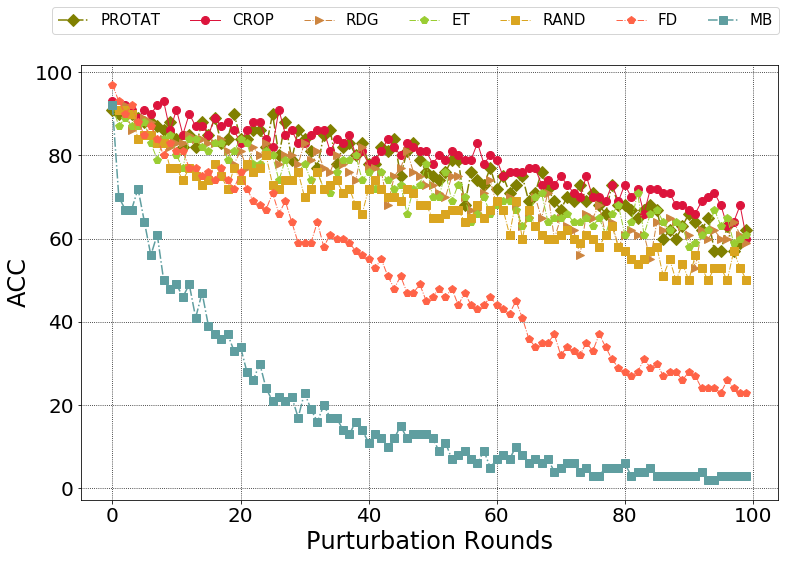

In [23]:
totalrounds = 100

plt.figure(figsize=(12.5,8))
# plt.figure(figsize=(12.5,4))
plt.plot(np.arange(totalrounds),AccList_PROTAT, color="olive",label='PROTAT', linestyle="-.", marker="D", linewidth=1.5, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_CROP, color="crimson",label='CROP', linestyle="-", marker="o", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_RDG, color="peru",label='RDG', linestyle="-.", marker=">", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_ET, color="yellowgreen",label='ET', linestyle="-.", marker="p", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_RAND, color="goldenrod",label='RAND', linestyle="-.", marker="s", linewidth=1.0, markersize = 8)


plt.plot(np.arange(totalrounds),AccList_FD[:100], color="tomato",label='FD', linestyle="-.", marker="p", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_SHIELD, color="olivedrab",label='SHIELD', linestyle="-.", marker="h", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_JPEG, color="chocolate",label='JPEG', linestyle="-.", marker="d", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_FPCA, color="chartreuse",label='FPCA', linestyle="-.", marker="o", linewidth=1.5, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_BdR, color="salmon",label='BdR', linestyle="-.", marker="v", linewidth=1.0, markersize = 8)


plt.plot(np.arange(totalrounds),AccList_MB, color="cadetblue",label='MB', linestyle="-.", marker="s", linewidth=1.5, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_GN, color="red",label='GN', linestyle="-.", marker="o", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_GB, color="orange",label='GB', linestyle="-.", marker=">", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_PD, color="indianred",label='PD', linestyle="-.", marker="H", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),AccList_CD, color="mediumaquamarine",label='CD', linestyle="-.", marker="p", linewidth=1.5, markersize = 8)


# plt.plot(np.arange(totalrounds),AccList, color="forestgreen", label='None',linestyle="--", marker="^", linewidth=1.0, markersize = 8)


plt.xlabel("Purturbation Rounds",fontsize=24)
plt.ylabel("ACC",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(fontsize=15,bbox_to_anchor=(1.012, 1.3),ncol=7)
plt.legend(fontsize=15,bbox_to_anchor=(1.012, 1.15),ncol=7)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_ModelAcc.png',bbox_inches='tight')
plt.show()

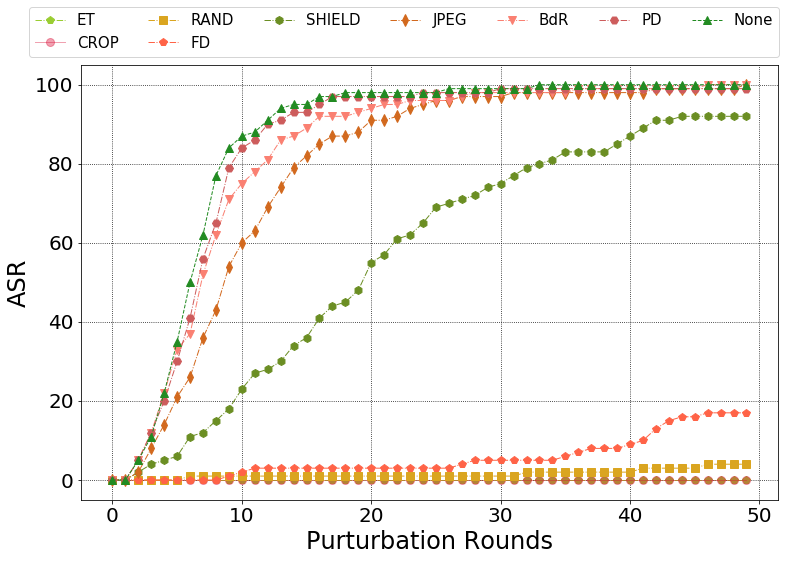

In [13]:
totalrounds = 50

plt.figure(figsize=(12.5,8))
# plt.figure(figsize=(12.5,4))
# plt.plot(np.arange(totalrounds),SuccessList_SSR, color="crimson",label='SSR', linestyle="-", marker="o", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_RC, color="goldenrod",label='RC', linestyle="-.", marker="s", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_ET, color="yellowgreen",label='ET', linestyle="-.", marker="p", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_FLIP, color="olivedrab",label='FLIP', linestyle="-.", marker="h", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_ROTA, color="chocolate",label='ROTA', linestyle="-.", marker="d", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_MB, color="salmon",label='MB', linestyle="-.", marker="v", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_GB, color="indianred",label='GB', linestyle="-.", marker="H", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_RG, color="yellowgreen",label='RG', linestyle="-.", marker="<", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_CLAHE, color="peru",label='CLAHE', linestyle="-.", marker=">", linewidth=1.0, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_JPEG, color="olive",label='JPEG', linestyle="-.", marker="D", linewidth=1.5, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_FPCA, color="chartreuse",label='FPCA', linestyle="-.", marker="o", linewidth=1.5, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_GN, color="cadetblue",label='GN', linestyle="-.", marker="s", linewidth=1.5, markersize = 8)
# plt.plot(np.arange(totalrounds),SuccessList_CD, color="mediumaquamarine",label='CD', linestyle="-.", marker="p", linewidth=1.5, markersize = 8)


plt.plot(np.arange(totalrounds),SuccessList_CROP, color="crimson",label='CROP', linestyle="-", marker="o", linewidth=1.0, markersize = 8,alpha=0.4)
plt.plot(np.arange(totalrounds),SuccessList_RAND, color="goldenrod",label='RAND', linestyle="-.", marker="s", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_FD[:50], color="tomato",label='FD', linestyle="-.", marker="p", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_SHIELD, color="olivedrab",label='SHIELD', linestyle="-.", marker="h", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_JPEG, color="chocolate",label='JPEG', linestyle="-.", marker="d", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_BdR, color="salmon",label='BdR', linestyle="-.", marker="v", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_PD, color="indianred",label='PD', linestyle="-.", marker="H", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList, color="forestgreen", label='None',linestyle="--", marker="^", linewidth=1.0, markersize = 8)


plt.xlabel("Purturbation Rounds",fontsize=24)
plt.ylabel("ASR",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15,bbox_to_anchor=(1.012, 1.15),ncol=7)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_AtkSucc.png',bbox_inches='tight')
plt.show()

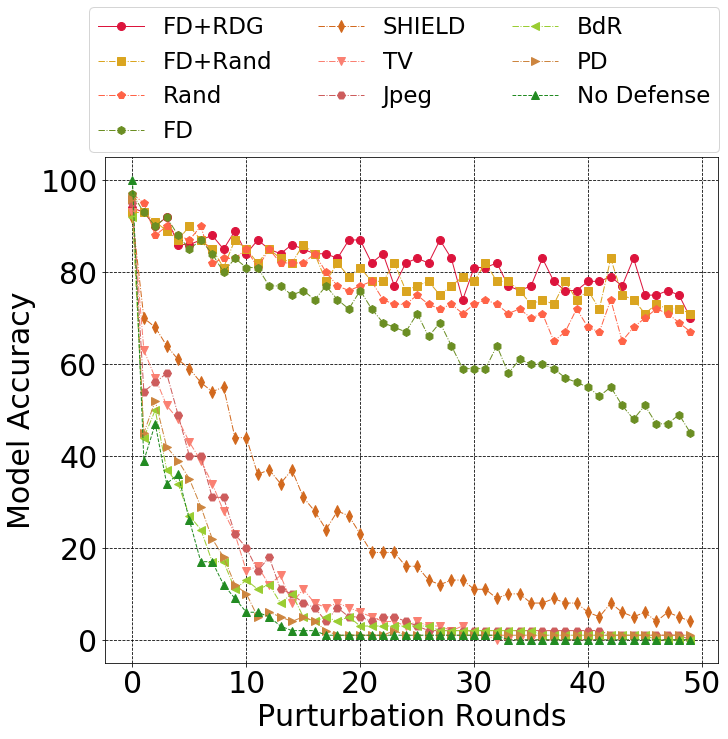

In [59]:
totalrounds = 50

plt.figure(figsize=(11,9.3))
plt.plot(np.arange(totalrounds),AccList_BPDA, color="crimson",label='FD+RDG', linestyle="-", marker="o", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_RAND_FD_BPDA, color="goldenrod",label='FD+Rand', linestyle="-.", marker="s", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_RAND_BPDA, color="tomato",label='Rand', linestyle="-.", marker="p", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_FD_BPDA[:50], color="olivedrab",label='FD', linestyle="-.", marker="h", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_SHIELD_BPDA, color="chocolate",label='SHIELD', linestyle="-.", marker="d", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_TV_BPDA, color="salmon",label='TV', linestyle="-.", marker="v", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_Jpeg_BPDA, color="indianred",label='Jpeg', linestyle="-.", marker="H", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_BitR_BPDA, color="yellowgreen",label='BdR', linestyle="-.", marker="<", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList_PD_BPDA, color="peru",label='PD', linestyle="-.", marker=">", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),AccList, color="forestgreen", label='No Defense',linestyle="--", marker="^", linewidth=1.0, markersize = 8)


plt.xlabel("Purturbation Rounds",fontsize=30)
plt.ylabel("Model Accuracy",fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=23,bbox_to_anchor=(1.02, 1.32),ncol=3)
plt.grid(color="k", linestyle="--")
plt.savefig(path+'/BPDA_ModelAcc.png',bbox_inches='tight')
plt.show()

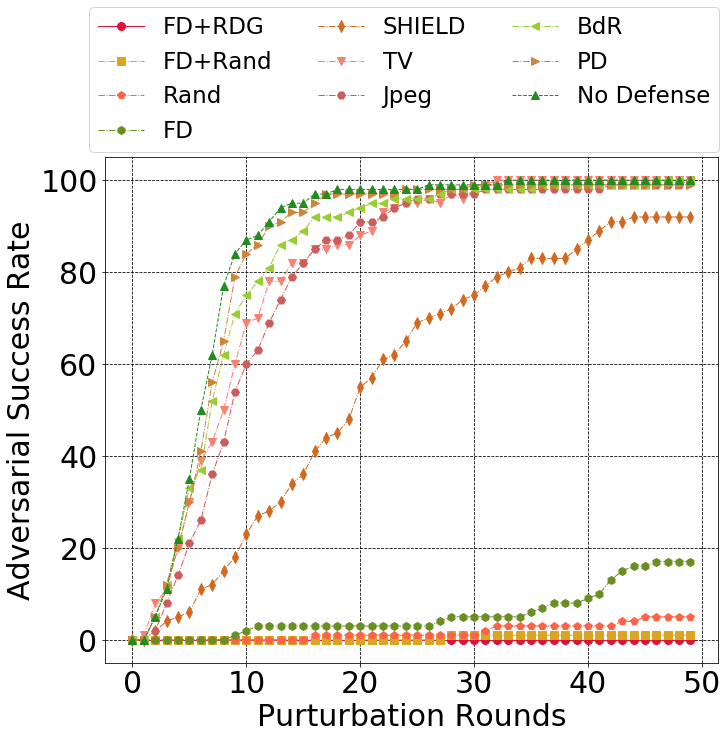

In [60]:
totalrounds = 50

plt.figure(figsize=(11,9.3))
plt.plot(np.arange(totalrounds),SuccessList_BPDA, color="crimson",label='FD+RDG', linestyle="-", marker="o", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_RAND_FD_BPDA, color="goldenrod",label='FD+Rand', linestyle="-.", marker="s", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_RAND_BPDA, color="tomato",label='Rand', linestyle="-.", marker="p", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_FD_BPDA[:50], color="olivedrab",label='FD', linestyle="-.", marker="h", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_SHIELD_BPDA, color="chocolate",label='SHIELD', linestyle="-.", marker="d", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_TV_BPDA, color="salmon",label='TV', linestyle="-.", marker="v", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_Jpeg_BPDA, color="indianred",label='Jpeg', linestyle="-.", marker="H", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_BitR_BPDA, color="yellowgreen",label='BdR', linestyle="-.", marker="<", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList_PD_BPDA, color="peru",label='PD', linestyle="-.", marker=">", linewidth=1.0, markersize = 8)
plt.plot(np.arange(totalrounds),SuccessList, color="forestgreen", label='No Defense',linestyle="--", marker="^", linewidth=1.0, markersize = 8)


plt.xlabel("Purturbation Rounds",fontsize=30)
plt.ylabel("Adversarial Success Rate",fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=23,bbox_to_anchor=(1.02, 1.32),ncol=3)
plt.grid(color="k", linestyle="--")
plt.savefig(path+'/BPDA_AtkSucc.png',bbox_inches='tight')
plt.show()

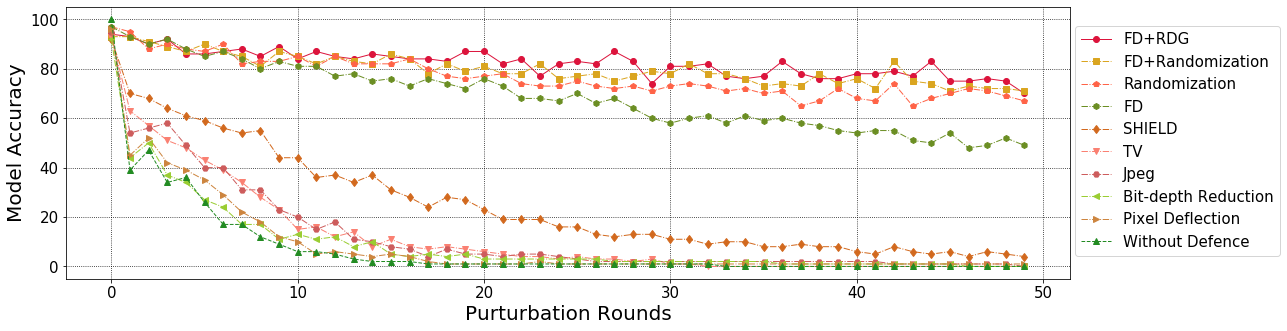

In [97]:
totalrounds = 50

plt.figure(figsize=(18,5))
plt.plot(np.arange(totalrounds),AccList_BPDA, color="crimson",label='FD+RDG', linestyle="-", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_RAND_FD_BPDA, color="goldenrod",label='FD+Randomization', linestyle="-.", marker="s", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_RAND_BPDA, color="tomato",label='Randomization', linestyle="-.", marker="p", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_FD_BPDA, color="olivedrab",label='FD', linestyle="-.", marker="h", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_SHIELD_BPDA, color="chocolate",label='SHIELD', linestyle="-.", marker="d", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_TV_BPDA, color="salmon",label='TV', linestyle="-.", marker="v", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_Jpeg_BPDA, color="indianred",label='Jpeg', linestyle="-.", marker="H", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_BitR_BPDA, color="yellowgreen",label='Bit-depth Reduction', linestyle="-.", marker="<", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList_PD_BPDA, color="peru",label='Pixel Deflection', linestyle="-.", marker=">", linewidth=1.0)
plt.plot(np.arange(totalrounds),AccList, color="forestgreen", label='Without Defence',linestyle="--", marker="^", linewidth=1.0)


plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Model Accuracy",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc=2, bbox_to_anchor=(1.005,0.93),borderaxespad = 0.)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_ModelAcc.png',bbox_inches='tight')
plt.show()

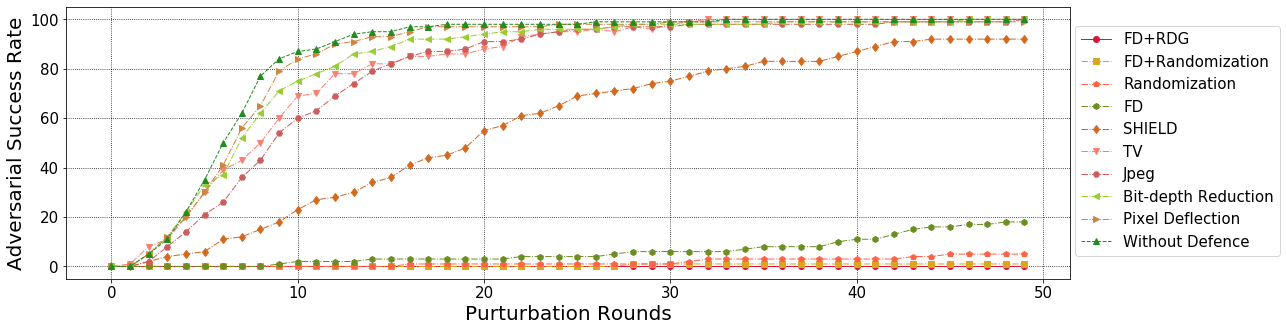

In [98]:
totalrounds = 50

plt.figure(figsize=(18,5))
plt.plot(np.arange(totalrounds),SuccessList_BPDA, color="crimson",label='FD+RDG', linestyle="-", marker="o", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_RAND_FD_BPDA, color="goldenrod",label='FD+Randomization', linestyle="-.", marker="s", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_RAND_BPDA, color="tomato",label='Randomization', linestyle="-.", marker="p", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_FD_BPDA, color="olivedrab",label='FD', linestyle="-.", marker="h", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_SHIELD_BPDA, color="chocolate",label='SHIELD', linestyle="-.", marker="d", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_TV_BPDA, color="salmon",label='TV', linestyle="-.", marker="v", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_Jpeg_BPDA, color="indianred",label='Jpeg', linestyle="-.", marker="H", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_BitR_BPDA, color="yellowgreen",label='Bit-depth Reduction', linestyle="-.", marker="<", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList_PD_BPDA, color="peru",label='Pixel Deflection', linestyle="-.", marker=">", linewidth=1.0)
plt.plot(np.arange(totalrounds),SuccessList, color="forestgreen", label='Without Defence',linestyle="--", marker="^", linewidth=1.0)


plt.xlabel("Purturbation Rounds",fontsize=20)
plt.ylabel("Adversarial Success Rate",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc=2, bbox_to_anchor=(1.005,0.93),borderaxespad = 0.)
plt.grid(color="k", linestyle=":")
plt.savefig(path+'/BPDA_AtkSucc.png',bbox_inches='tight')
plt.show()